# Analysis of Immigration Canada Subreddit

## Data Cleaning

In [209]:
# Importing libraries
import nltk
import pandas as pd
import datetime as dt
from datetime import datetime
import seaborn as sns
from ydata_profiling import ProfileReport
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
palette = sns.color_palette("Paired")
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import ssl
import plotly.express as px

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ngocphan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Data Import

In [210]:
# Importing reddit data from csv
df_all = pd.read_csv('reddit_all_posts.csv')
df_all.name = 'df_all'
df_mixed = pd.read_csv('reddit_mixed_posts.csv')
df_mixed.name = 'df_mixed'
df_top = pd.read_csv('reddit_top_posts.csv')
df_top.name = 'df_top'

# Ensuring 'selftext' column or submission body type string
df_all['selftext'] = df_all['selftext'].astype(str)
df_mixed['selftext'] = df_mixed['selftext'].astype(str)
df_top['selftext'] = df_top['selftext'].astype(str)

# Rename
df_top = df_top.rename(columns={"created":"created_utc"})

### Missing body submission

In [211]:
# Identify the columns with duplicate submission or missing submission body
boolean = df_all.duplicated(subset=['selftext'])

In [212]:
df_all[boolean]['selftext']

14                                                     nan
15                                                     nan
25                                                     nan
31                                                     nan
35                                                     nan
                               ...                        
63816                                            [removed]
63817    My brother is in his mid 20s and has worked fo...
63818                                            [removed]
63819                                            [removed]
63820                                            [removed]
Name: selftext, Length: 63217, dtype: object

In [213]:
# Identify the number of submission body removed
df_all[df_all['selftext'] == '[removed]'].count()

Unnamed: 0         21679
Year               21679
selftext           21679
author             21679
author_fullname    17303
title              21679
link_flair_text    18237
ups                  373
num_comments       21679
id                 21679
media_embed        21679
created_utc        21679
upvote_ratio       20986
dtype: int64

In [214]:
# View submissions with submission body removed to identify if these records should be removed
df_all[df_all['selftext'] == '[removed]'].head()

Unnamed: 0  Year   selftext              author author_fullname  \
321         321  2015  [removed]  immigrationxiphias             NaN   
328         328  2015  [removed]  immigrationxiphias             NaN   
329         329  2015  [removed]           [deleted]             NaN   
340         340  2015  [removed]  immigrationxiphias             NaN   
362         362  2015  [removed]       ghimmigration             NaN   

                                                 title link_flair_text  ups  \
321                                  Migrate to Canada             NaN  1.0   
328                Canada Immigration Services Calgary             NaN  1.0   
329                Canada Immigration Services Calgary             NaN  1.0   
340     XIPHIAS IMMIGRATION REVIEWS - CUSTOMER REVIEWS             NaN  1.0   
362  Golden Hands Immigration Inc. GH Immigration Inc.             NaN  0.0   

     num_comments      id media_embed          created_utc  upvote_ratio  
321             0  3yncn5          {}  2015-12-29 12:10:57           NaN  
328             0  3y9xlv          {}  2015-12-26 10:48:03           NaN  
329             0  3y9wxe          {}  2015-12-26 10:37:57           NaN  
340             0  3xxptx          {}  2015-12-23 06:58:44           NaN  
362             0  3x1rxa          {}  2015-12-16 06:27:00           NaN

In [215]:
# Identify submissions with no submission body
df_all[df_all['selftext'] =='nan'].count()

Unnamed: 0         3084
Year               3084
selftext           3084
author             3084
author_fullname    2234
title              3084
link_flair_text    1864
ups                 605
num_comments       3084
id                 3084
media_embed        3084
created_utc        3084
upvote_ratio       1691
dtype: int64

In [216]:
# View submissions with no submission body to identify if these records should be kept
df_all[df_all['selftext'] == 'nan'].head(5)

Unnamed: 0  Year selftext     author author_fullname  \
9            9  2013      nan   CramBoom             NaN   
14          14  2013      nan   ranger28             NaN   
15          15  2013      nan  [deleted]             NaN   
25          25  2013      nan  ninjah778             NaN   
31          31  2013      nan  [deleted]             NaN   

                                                title link_flair_text  ups  \
9   So you think you're Canadian? - Game-show to t...             NaN  1.0   
14  Canadian Immigration | live and work in Canada...             NaN  0.0   
15  Canada’s new immigration program welcomes firs...             NaN  1.0   
25  Immigration tips for students/visitors - getti...             NaN  1.0   
31  At the moment. All posts seem to be hitting th...             NaN  4.0   

    num_comments      id                                        media_embed  \
9              0  1pbs0y  {'width': 600, 'height': 450, 'content': '&lt;...   
14             0  1md4wi                                                 {}   
15             0  1kknpp                                                 {}   
25             0  1bflor                                                 {}   
31             4  189fty                                                 {}   

            created_utc  upvote_ratio  
9   2013-10-27 18:31:22           NaN  
14  2013-09-14 06:22:35           NaN  
15  2013-08-17 22:32:50           NaN  
25  2013-04-01 17:31:55           NaN  
31  2013-02-10 20:05:51           NaN

In [217]:
# Function to remove submissions with removed body or Nan
def submission_body(df):
    """Function to drop rows associated with submissions where selftext is removed or Nan
    Input: Dataframe
    Output: Count of submissions with no body, count of submission with removed body, and dataframe info"""
    no_body = df[df['selftext'] == 'nan']
    removed = df[df['selftext'] == '[removed]']
    df.drop(no_body.index, inplace=True)
    df.drop(removed.index, inplace=True)
    print('Submissions with no body removed:', no_body.count())
    print('Submission with removed body:', removed.count())
    print(df.info())
    return df

In [218]:
# Apply function to current dataframes
df_all_analysis = submission_body(df_all.copy())
df_mixed_analysis = submission_body(df_mixed.copy())
df_top_analysis = submission_body(df_top.copy())

df_all_analysis['link_flair_text'] = df_all_analysis['link_flair_text'].astype(str)
df_mixed_analysis['link_flair_text'] = df_mixed_analysis['link_flair_text'].astype(str)
df_top_analysis['link_flair_text'] = df_top_analysis['link_flair_text'].astype(str)

Submissions with no body removed: Unnamed: 0         3084
Year               3084
selftext           3084
author             3084
author_fullname    2234
title              3084
link_flair_text    1864
ups                 605
num_comments       3084
id                 3084
media_embed        3084
created_utc        3084
upvote_ratio       1691
dtype: int64
Submission with removed body: Unnamed: 0         21679
Year               21679
selftext           21679
author             21679
author_fullname    17303
title              21679
link_flair_text    18237
ups                  373
num_comments       21679
id                 21679
media_embed        21679
created_utc        21679
upvote_ratio       20986
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39058 entries, 0 to 63817
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       39058 non-null  int64  
 1   Year             3905

### Missing category & Other category

#### Wordcloud of submissions with missing or other category

In [219]:
# Function for worldcloud visualization
def word_cloud(df, category=None):
    # If specific category is not required
    if category is None:
        text = "".join(i for i in df['selftext'])
    # If specific category is required
    else: 
        mask = (df['link_flair_text'].isna())|(df['link_flair_text'] == category)
        df_viz = df[mask]
        text = "".join(i for i in df_viz['selftext'])
    # Stopwords   
    custom_stop_words = ['question', 'really', 'go','years', 'trying', 
                         'advice','anything','take', 'day', 'much', 
                         'think', 'one', 'sure', 'wondering', 'seem', 
                         'ask', 'September', 'make', 'S', 'thinking', 
                         'Canadian', 'going', 'lot', 'hope', 'give', 
                         'Canada', 'know', 'want', 'now', 'will', 'got', 
                         'year', 'still possible', 'need','able', 'apply',
                         'say', 'received', 'U', 'help', 'anyone','month',
                         'looking', 'application']
    stopwords = list(STOPWORDS) + custom_stop_words
    # Visualization
    wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='white', colormap='Pastel1', stopwords=stopwords).generate(text)
    # Display wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return None

# Recategorization function
def category_change(row):
    PR_related = ['PR card', 'permanent resident', 'PR']
    student = ['study permit', 'student visa']
    if (row['link_flair_text'] == 'Other')|(row['link_flair_text'] == 'nan'):
        if ('work permit' in row['selftext']):
            row['link_flair_text'] = 'Work Permit'
        elif (x in row['selftext'] for x in student):
            row['link_flair_text'] = 'Study Permit'
        elif ('express entry' in row['selftext']):
            row['link_flair_text'] = 'Express Entry'
        elif any(x in row['selftext'] for x in PR_related):
            row['link_flair_text'] = 'Permanent Resident'
        else: None
    return row


#### All posts

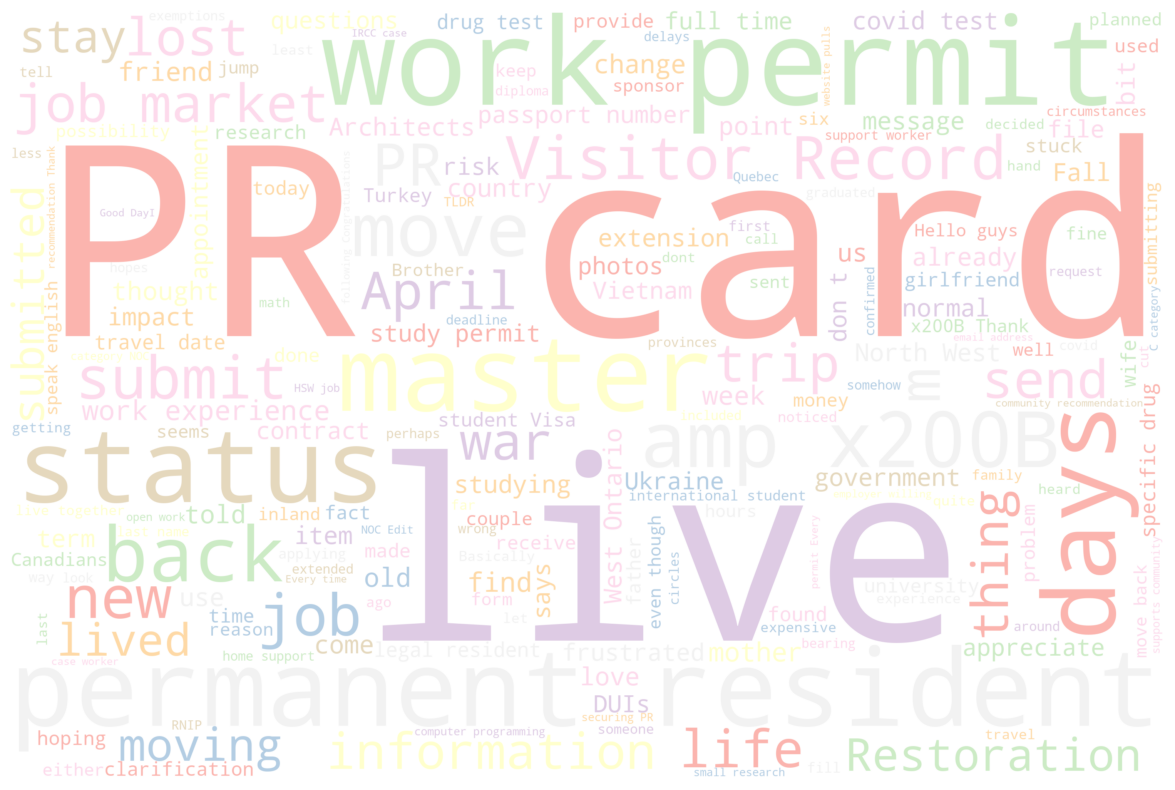

In [220]:
word_cloud(df_all_analysis, 'Other')

In [221]:
df_all_analysis.value_counts('link_flair_text')

link_flair_text
Express Entry      6967
nan                6786
Study Permit       5531
Other              5529
Work Permit        4399
Sponsorship        4220
Visitor Visa       2411
Citizenship        1047
PNP                 893
Working Holiday     757
Quebec              518
dtype: int64

In [222]:
df_all_adj = df_all_analysis.apply(category_change, axis=1)

In [223]:
df_all_adj.value_counts('link_flair_text')

link_flair_text
Study Permit       16534
Express Entry       6967
Work Permit         5711
Sponsorship         4220
Visitor Visa        2411
Citizenship         1047
PNP                  893
Working Holiday      757
Quebec               518
dtype: int64

#### Mixed posts

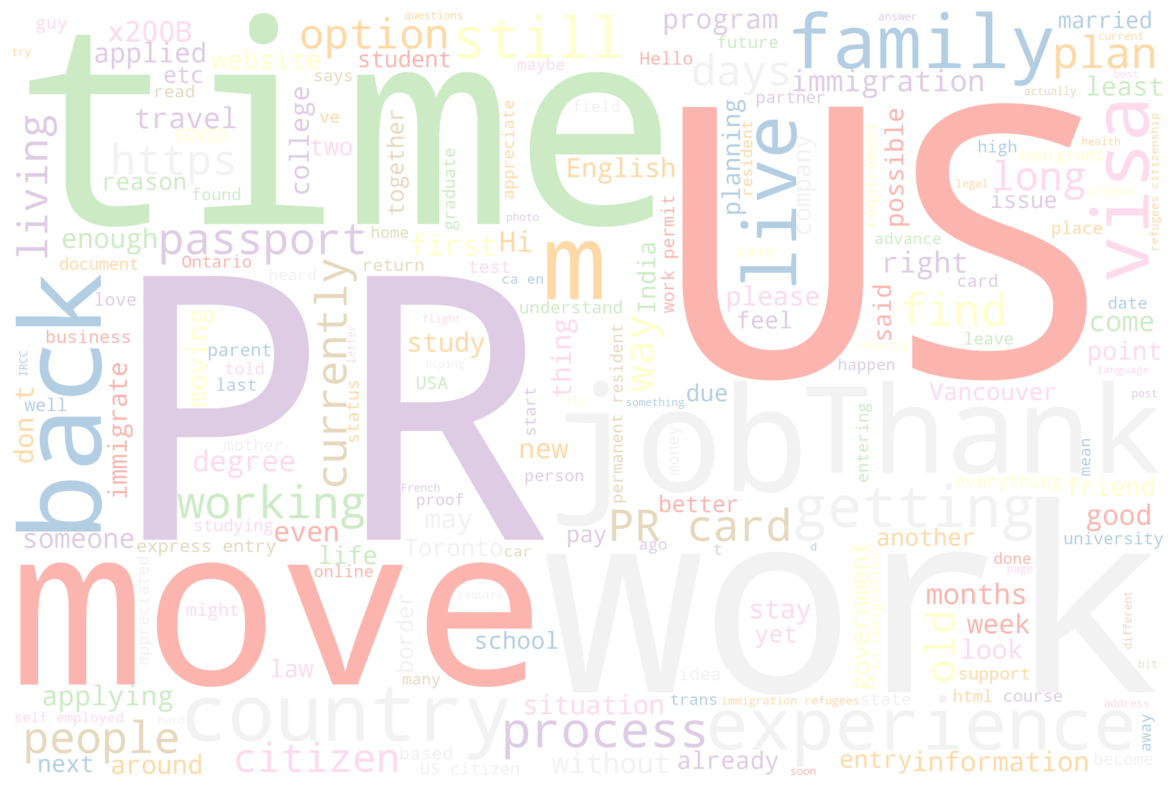

In [224]:
word_cloud(df_mixed_analysis, 'Other')

In [225]:
df_mixed_analysis.value_counts('link_flair_text')

link_flair_text
Other                     228
Express Entry             183
Study Permit              113
Work Permit               108
Sponsorship                92
nan                        89
Visitor Visa               48
Citizenship                41
PNP                        21
Quebec                     17
Public Policy pathways      9
Working Holiday             8
Meta                        1
dtype: int64

In [226]:
df_mixed_adj = df_mixed_analysis.apply(category_change, axis=1)

In [227]:
df_mixed_adj.value_counts('link_flair_text')

link_flair_text
Study Permit              416
Express Entry             183
Work Permit               122
Sponsorship                92
Visitor Visa               48
Citizenship                41
PNP                        21
Quebec                     17
Public Policy pathways      9
Working Holiday             8
Meta                        1
dtype: int64

#### Top posts

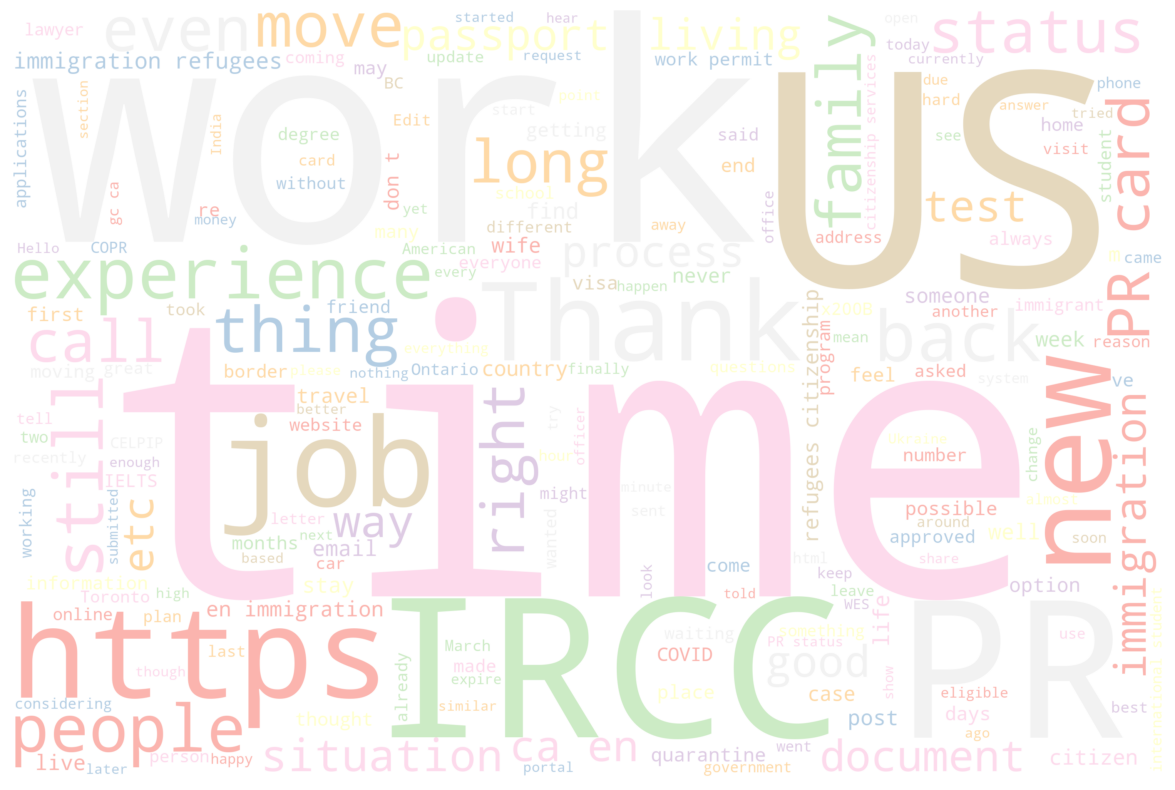

In [228]:
word_cloud(df_top_analysis, 'Other')

In [229]:
df_top_analysis.value_counts('link_flair_text')

link_flair_text
Express Entry             236
Other                     206
Work Permit                96
Study Permit               85
Sponsorship                83
nan                        59
Citizenship                48
Visitor Visa               22
PNP                        12
Meta                        9
Public Policy pathways      9
Working Holiday             6
Quebec                      5
dtype: int64

In [230]:
df_top_adj = df_top_analysis.apply(category_change, axis=1)

In [231]:
df_top_adj.value_counts('link_flair_text')

link_flair_text
Study Permit              330
Express Entry             236
Work Permit               116
Sponsorship                83
Citizenship                48
Visitor Visa               22
PNP                        12
Meta                        9
Public Policy pathways      9
Working Holiday             6
Quebec                      5
dtype: int64

In [232]:
# Categories available
all_categories = df_all_analysis['link_flair_text'].unique()
print(all_categories)

['nan' 'Working Holiday' 'Study Permit' 'Visitor Visa' 'Express Entry'
 'Other' 'Sponsorship' 'Work Permit' 'PNP' 'Quebec' 'Citizenship']


### Datetime column transformation

In [233]:
def datetime_transform(row):
    datetime_object = datetime.strptime(row['created_utc'], '%Y-%m-%d %H:%M:%S')
    row['month_utc'] = datetime_object.month
    row['Year'] = datetime_object.year
    row['day_utc'] = datetime_object.date
    return row

In [234]:
df_all_adj = df_all_adj.apply(datetime_transform, axis=1)
df_mixed_adj = df_mixed_adj.apply(datetime_transform, axis=1)
df_top_adj = df_top_adj.apply(datetime_transform, axis=1)


## Data Visualization

### All posts

In [235]:
df_all_adj.head(3)

Unnamed: 0  Year                                           selftext  \
0           0  2013  I am Indian. I want to study in Canada and I w...   
1           1  2013  So, recently, a friend of mine worked on a doc...   
2           2  2013  I have friend from Denmark who is very interes...   

        author author_fullname  \
0  geekpirate1             NaN   
1    [deleted]             NaN   
2   BreaksFull             NaN   

                                               title link_flair_text  ups  \
0                                  Applying for Visa    Study Permit  1.0   
1  Petition to let Naim stay in Canada under refu...    Study Permit  1.0   
2  I have a friend looking to immigrate to Canada...    Study Permit  1.0   

   num_comments      id media_embed          created_utc  upvote_ratio  \
0             2  1tusw5          {}  2013-12-28 04:06:59           NaN   
1             0  1szl5v          {}  2013-12-16 05:30:08           NaN   
2             6  1ssxf6          {}  2013-12-13 16:25:00           NaN   

   month_utc                                            day_utc  
0         12  <built-in method date of datetime.datetime obj...  
1         12  <built-in method date of datetime.datetime obj...  
2         12  <built-in method date of datetime.datetime obj...

<AxesSubplot:xlabel='Year', ylabel='Count'>

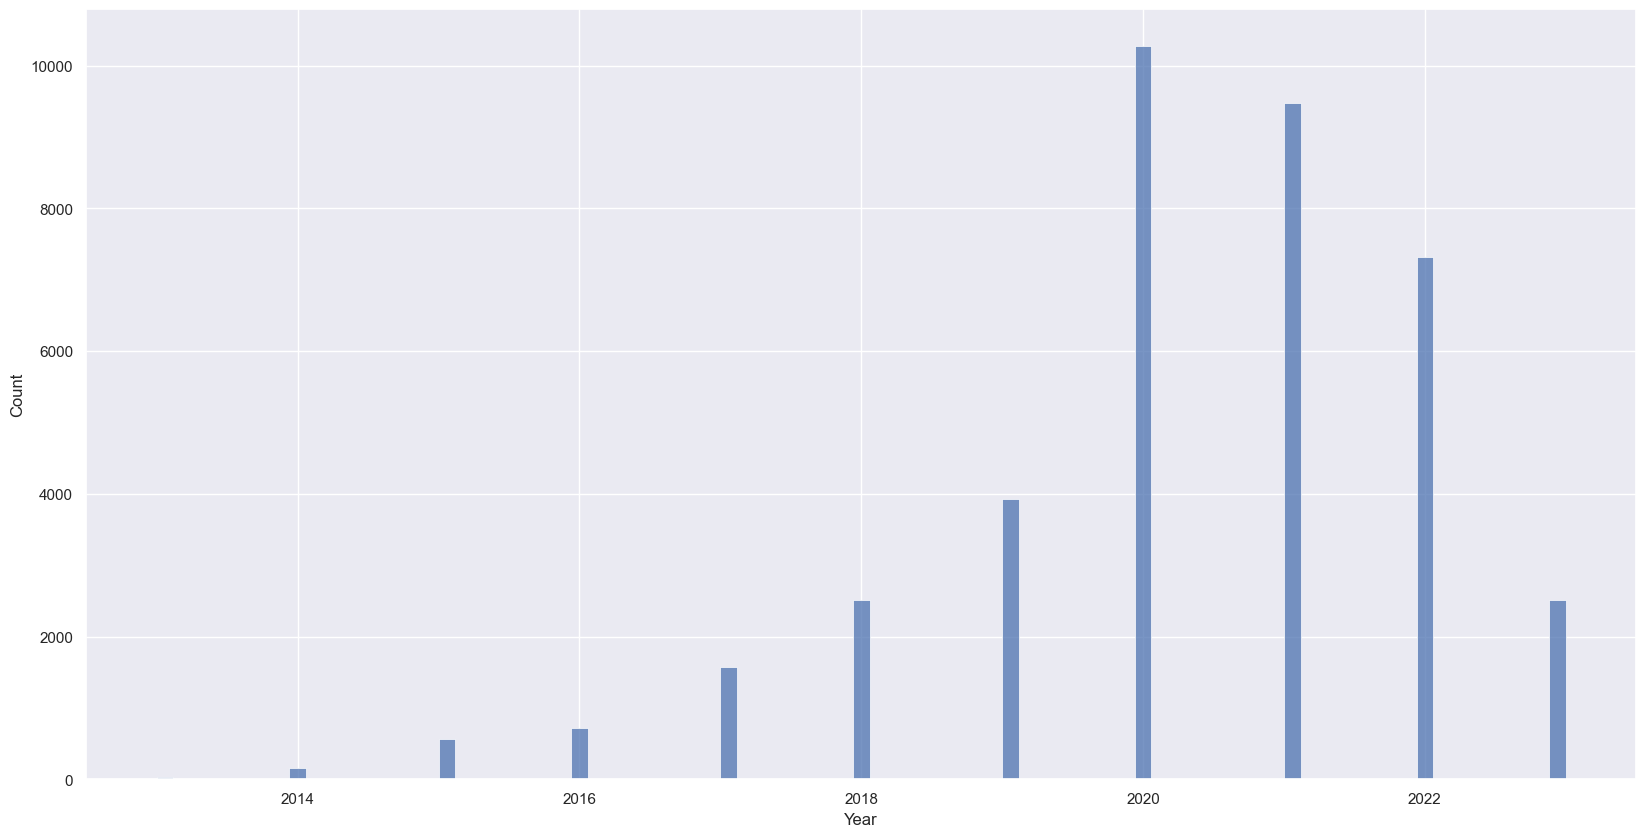

In [236]:
# Histogram of submissions by year
sns.histplot(df_all_adj, x='Year',linewidth=0.5)

<AxesSubplot:xlabel='link_flair_text', ylabel='Count'>

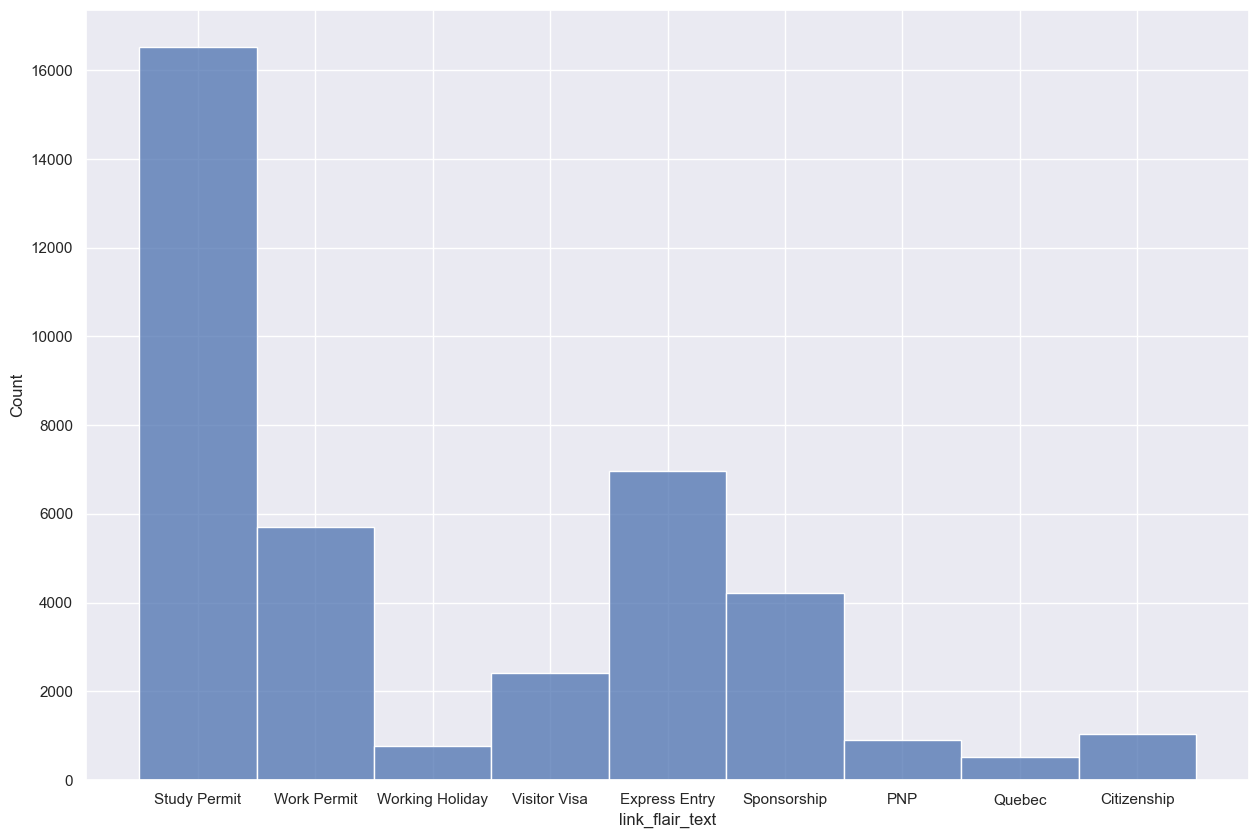

In [237]:
# Histogram of submissions by program requested
sns.set(rc={"figure.figsize":(15, 10)})
sns.histplot(df_all_adj, x='link_flair_text')

In [348]:
df_all_count = df_all_adj.groupby(by=['link_flair_text', 'Year']).count()['created_utc'].reset_index()
df_all_count = df_all_count.sort_values(by=['Year']).reset_index(drop=True)
df_all_count = df_all_count.rename(columns={"link_flair_text": "Program", "created_utc": "Submission counts"})

In [353]:
# Line plot of submissions by year and by program 
px.line(df_all_count, x='Year', y='Submission counts', color="Program", title='Submissions by program and by year - All posts')

### Mixed opinion posts

In [355]:
df_mixed_adj.head(3)

Unnamed: 0 author_fullname               author  \
0           0     t2_2hky4lg1  thepeopleschoice666   
1           1     t2_6ngrzp8c           AngryDrago   
2           2     t2_3z4odiz8            wardway69   

                                            selftext  \
0  I understand that this sub is intended for us ...   
1  MtF American guy here. Due to the recent laws ...   
2  I am Syrian I have been living in limbo going ...   

                                               title  upvote_ratio  ups  \
0  META: People who downvote without adding any help          0.53    6   
1  I am a transgender American. Can I apply for r...          0.47    0   
2         Sorry for the language. But fr am I fucked          0.52    1   

  link_flair_text       id  num_comments          created_utc media_embed  \
0    Study Permit   fbroi5            18  2020-03-01 09:23:15          {}   
1    Study Permit   uibvnz            14  2022-05-04 17:30:02          {}   
2    Study Permit  10uj639            10  2023-02-05 18:14:28          {}   

   month_utc  Year                                            day_utc  \
0          3  2020  <built-in method date of datetime.datetime obj...   
1          5  2022  <built-in method date of datetime.datetime obj...   
2          2  2023  <built-in method date of datetime.datetime obj...   

  sentiment                                   sentiment_scores  \
0   neutral  {'neg': 0.171, 'neu': 0.719, 'pos': 0.11, 'com...   
1   neutral  {'neg': 0.087, 'neu': 0.872, 'pos': 0.042, 'co...   
2   neutral  {'neg': 0.025, 'neu': 0.933, 'pos': 0.042, 'co...   

   sentiment_negative  sentiment_positive  sentiment_neutral  
0               0.171               0.110              0.719  
1               0.087               0.042              0.872  
2               0.025               0.042              0.933

<AxesSubplot:xlabel='Year', ylabel='Count'>

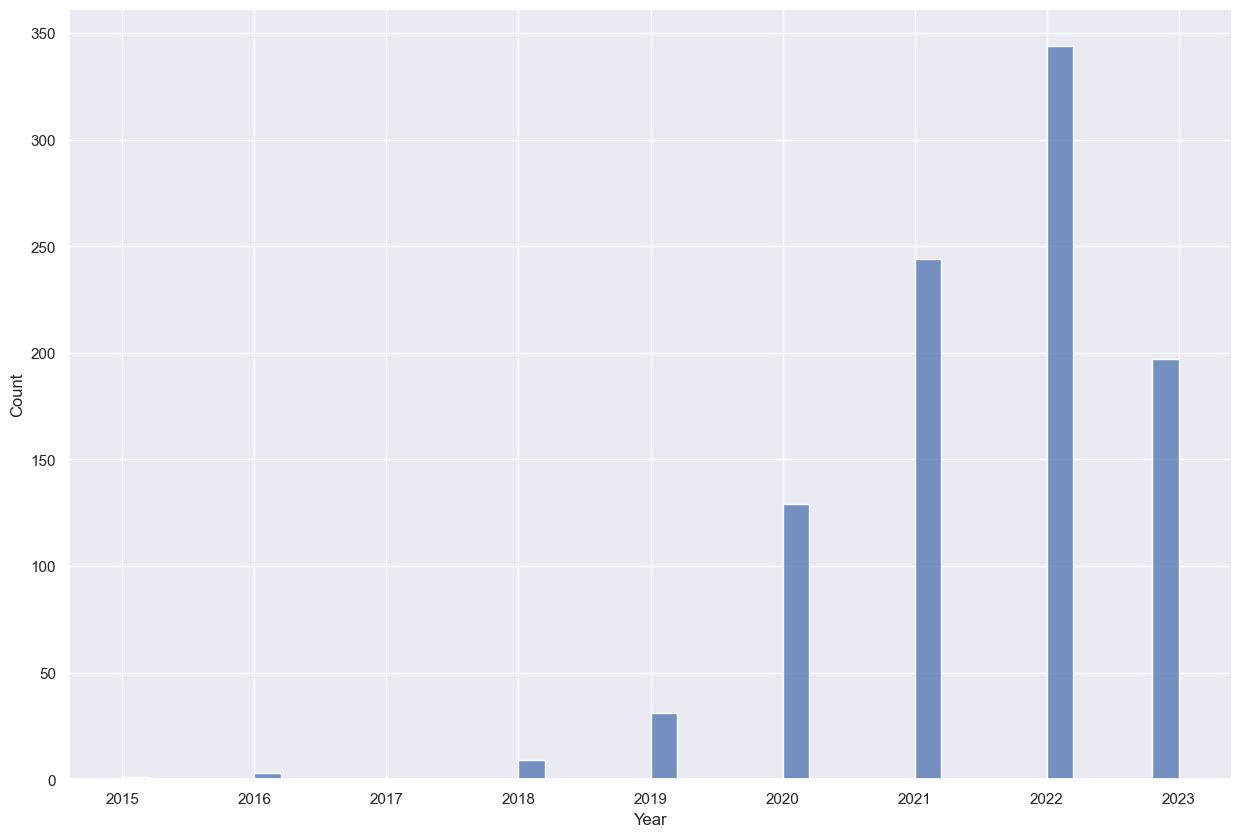

In [242]:
sns.histplot(df_mixed_adj, x='Year')

<AxesSubplot:xlabel='link_flair_text', ylabel='Count'>

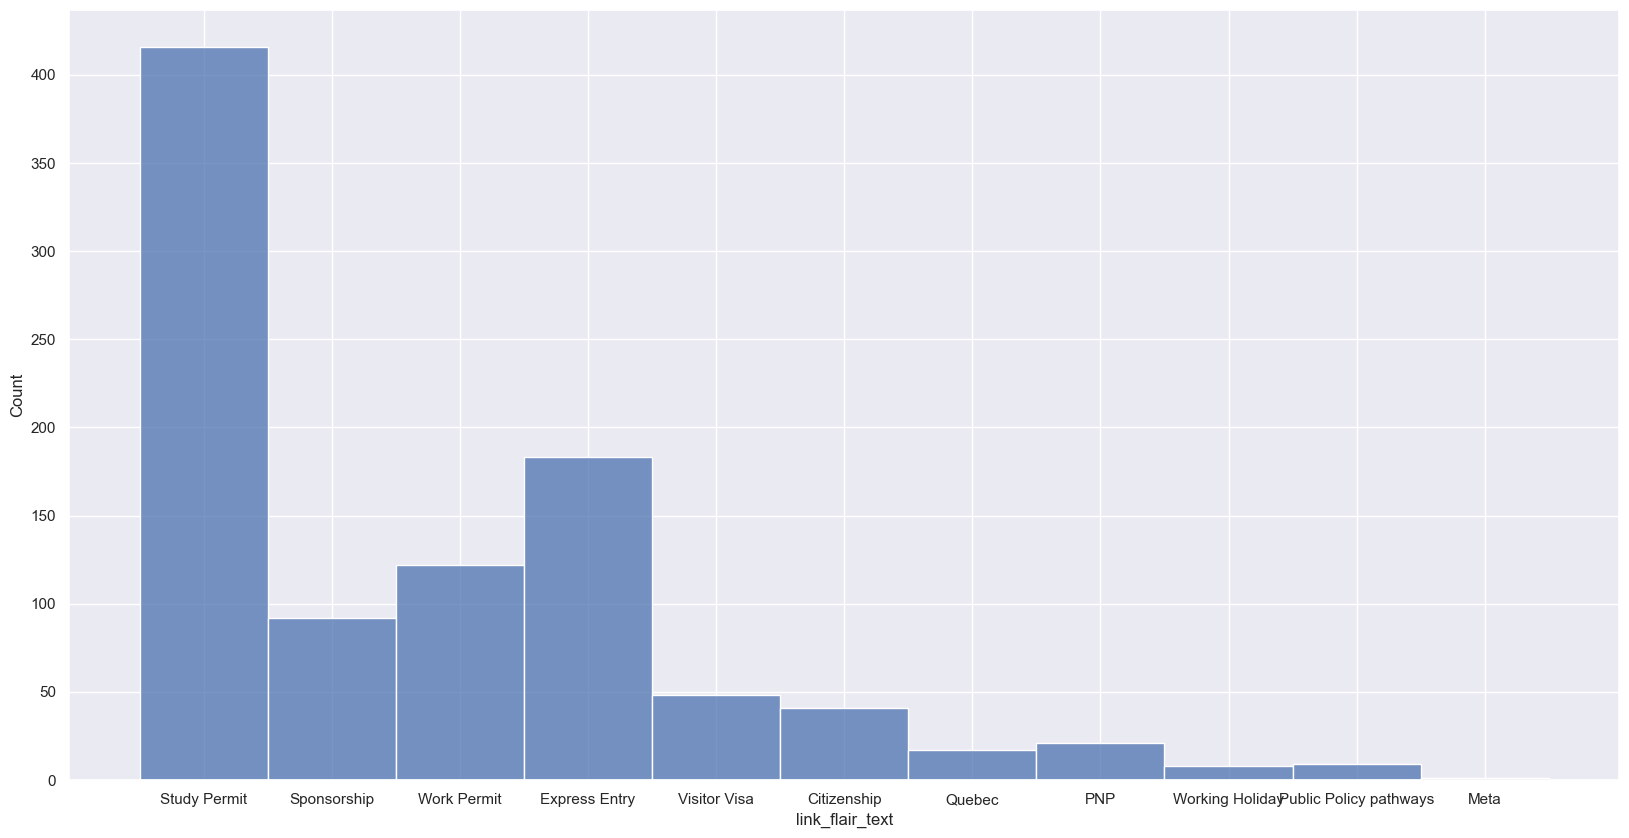

In [243]:
# Histogram of submissions by program requested
sns.set(rc={"figure.figsize":(20, 10)})
sns.histplot(df_mixed_adj, x='link_flair_text')

In [354]:
df_mixed_count = df_mixed_adj.groupby(by=['link_flair_text', 'Year']).count()['created_utc'].reset_index()
df_mixed_count = df_mixed_count.sort_values(by=['Year']).reset_index(drop=True)
df_mixed_count = df_mixed_count.rename(columns={"link_flair_text": "Program", "created_utc": "Submission counts"})

# Line plot of submissions by year and by program 
px.line(df_mixed_count, x='Year', y='Submission counts', color='Program', title="Submissions by program by year - Controversial posts")

### Top posts

In [356]:
df_top_adj.head(3)

Unnamed: 0                                           selftext  \
0           0  Hi guys,\n\nI've been lurking around this sub ...   
2           2  Minutes ago I received an email notifying me t...   
4           4  Invite interview: January 24th 2023  \nOath: J...   

  author_fullname                                              title  ups  \
0       t2_14v9x4  Advice from a Canadian Immigration veteran - D...  451   
2      t2_y8cp6w6                   I Just Became Permanent Resident  346   
4     t2_vpp1zhff                       I am a Canadian Citizen!!!!!  310   

  link_flair_text  upvote_ratio media_embed          created_utc  \
0   Express Entry          0.97          {}  2020-09-27 16:06:02   
2    Study Permit          0.96          {}  2021-02-17 20:09:12   
4     Citizenship          0.98          {}  2023-01-27 01:21:53   

   num_comments       id  month_utc  Year  \
0            67   j0tmbd          9  2020   
2            52   lm3ecw          2  2021   
4           101  10m8clq          1  2023   

                                             day_utc sentiment  \
0  <built-in method date of datetime.datetime obj...   neutral   
2  <built-in method date of datetime.datetime obj...   neutral   
4  <built-in method date of datetime.datetime obj...   neutral   

                                    sentiment_scores  sentiment_negative  \
0  {'neg': 0.036, 'neu': 0.846, 'pos': 0.118, 'co...               0.036   
2  {'neg': 0.033, 'neu': 0.767, 'pos': 0.199, 'co...               0.033   
4  {'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'comp...               0.000   

   sentiment_positive  sentiment_neutral  
0               0.118              0.846  
2               0.199              0.767  
4               0.175              0.825

<AxesSubplot:xlabel='Year', ylabel='Count'>

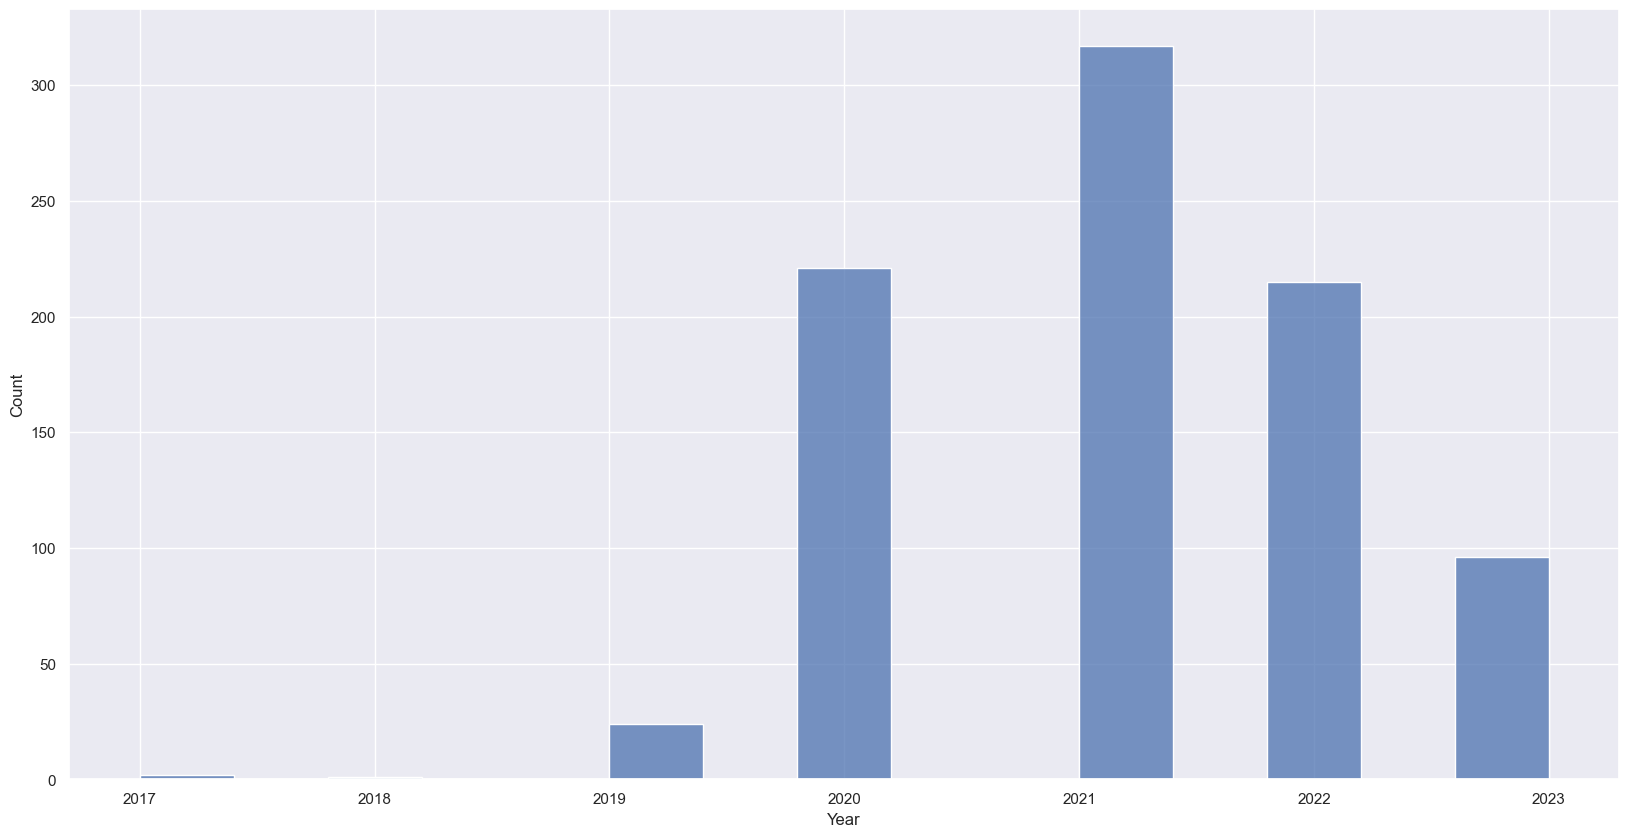

In [246]:
sns.histplot(df_top_adj, x='Year')

<AxesSubplot:xlabel='link_flair_text', ylabel='Count'>

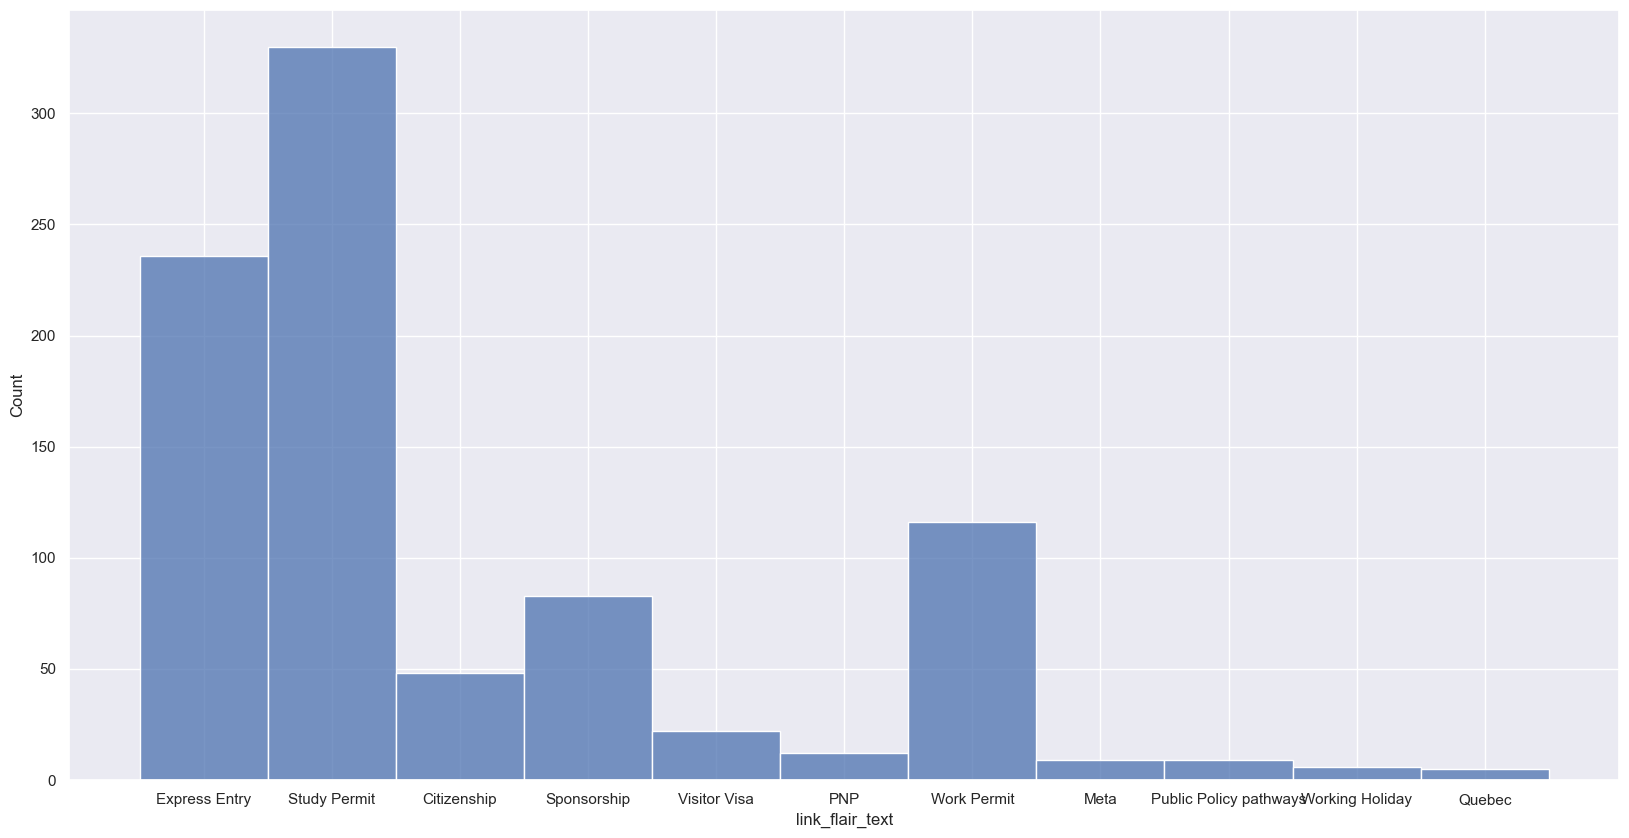

In [247]:
sns.histplot(df_top_adj, x='link_flair_text')

In [360]:
df_top_count = df_top_adj.groupby(by=['Year', 'link_flair_text']).count()['created_utc'].reset_index()
df_top_count = df_top_count.sort_values(by=['Year']).reset_index(drop=True)
df_top_count = df_top_count.rename(columns={"link_flair_text": "Program", "created_utc":"Submission counts" })
px.line(df_top_count, x='Year', y='Submission counts', color='Program', title='Submissions by program and by year - Top posts')

## Quantitative Deliverables

### Understanding Immigration programs

#### a. Discussion of programs

In [249]:
# Total comments per category all time
total_comments= df_all_adj.groupby(by='link_flair_text').sum()['num_comments']
total_comments.sort_values(ascending=False)

link_flair_text
Study Permit       75502
Express Entry      25125
Work Permit        17876
Sponsorship        15815
Visitor Visa        4467
Citizenship         1516
Working Holiday     1473
PNP                 1062
Quebec               858
Name: num_comments, dtype: int64

<AxesSubplot:xlabel='link_flair_text', ylabel='num_comments'>

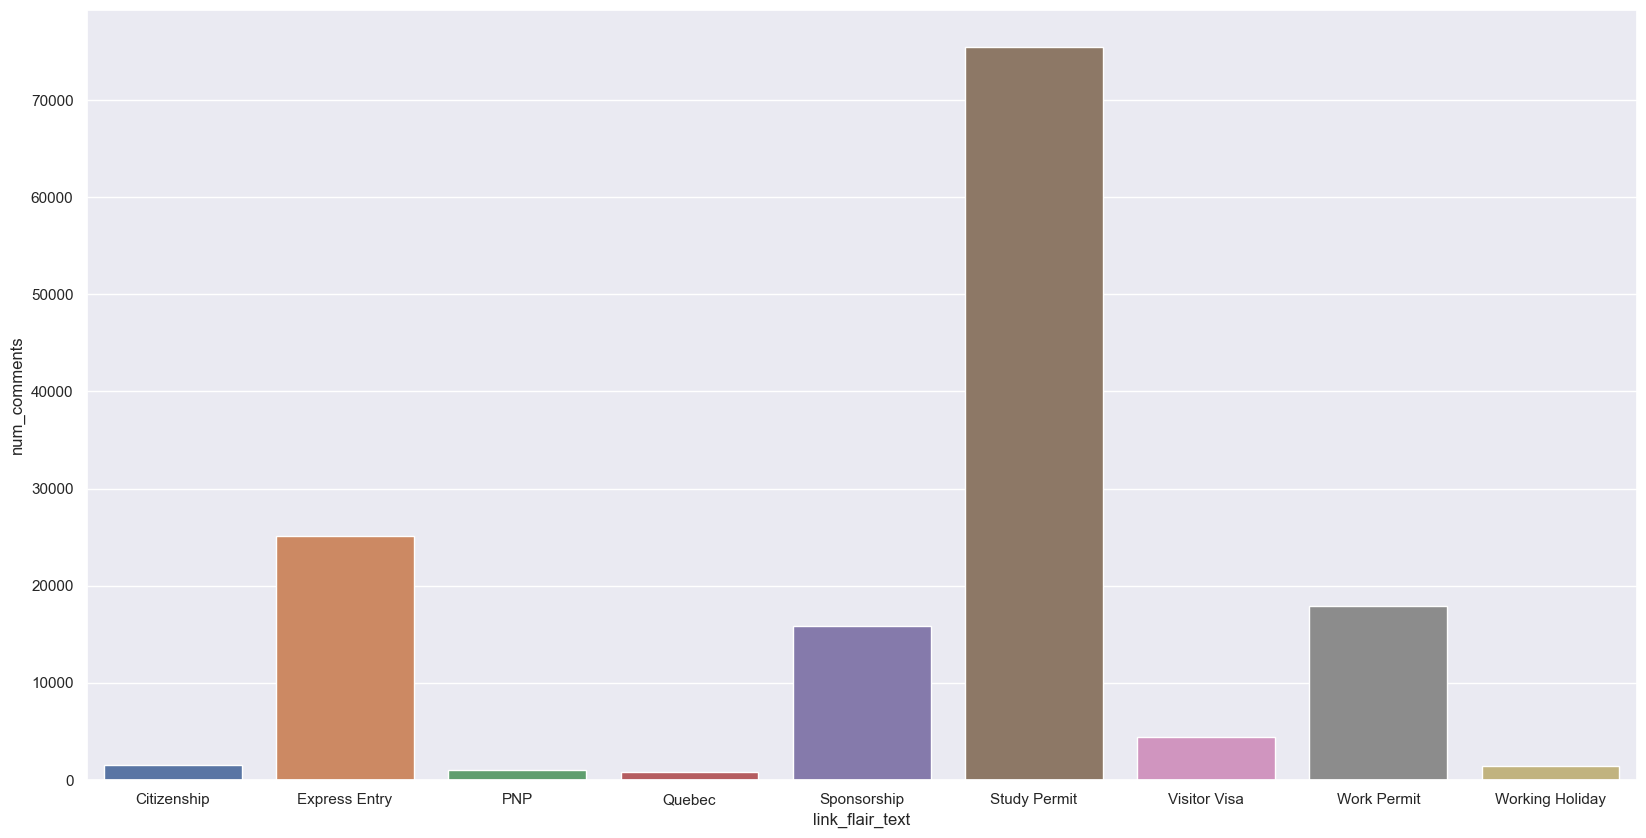

In [250]:
# Plots of total comments by category
total_comments = total_comments.to_frame().reset_index()
sns.barplot(total_comments, x='link_flair_text', y='num_comments')

In [338]:
# Total comments per category per year
total_comments_year = df_all_adj.groupby(by=['link_flair_text', 'Year']).sum()['num_comments'].reset_index()
total_comments_year = total_comments_year.sort_values(by=['Year']).reset_index(drop=True)
total_comments_year = total_comments_year.rename(columns={"link_flair_text": "Program"})
px.line(total_comments_year, x='Year', y='num_comments', color='Program', title='Total comments by program by year')

In [251]:
# Average comments per category all time
average_comment_all = df_all_adj.groupby(by='link_flair_text').mean()['num_comments']
average_comment_all.sort_values(ascending=False)

link_flair_text
Study Permit       4.566469
Sponsorship        3.747630
Express Entry      3.606287
Work Permit        3.130100
Working Holiday    1.945839
Visitor Visa       1.852758
Quebec             1.656371
Citizenship        1.447947
PNP                1.189250
Name: num_comments, dtype: float64

<AxesSubplot:xlabel='link_flair_text', ylabel='avg_comments'>

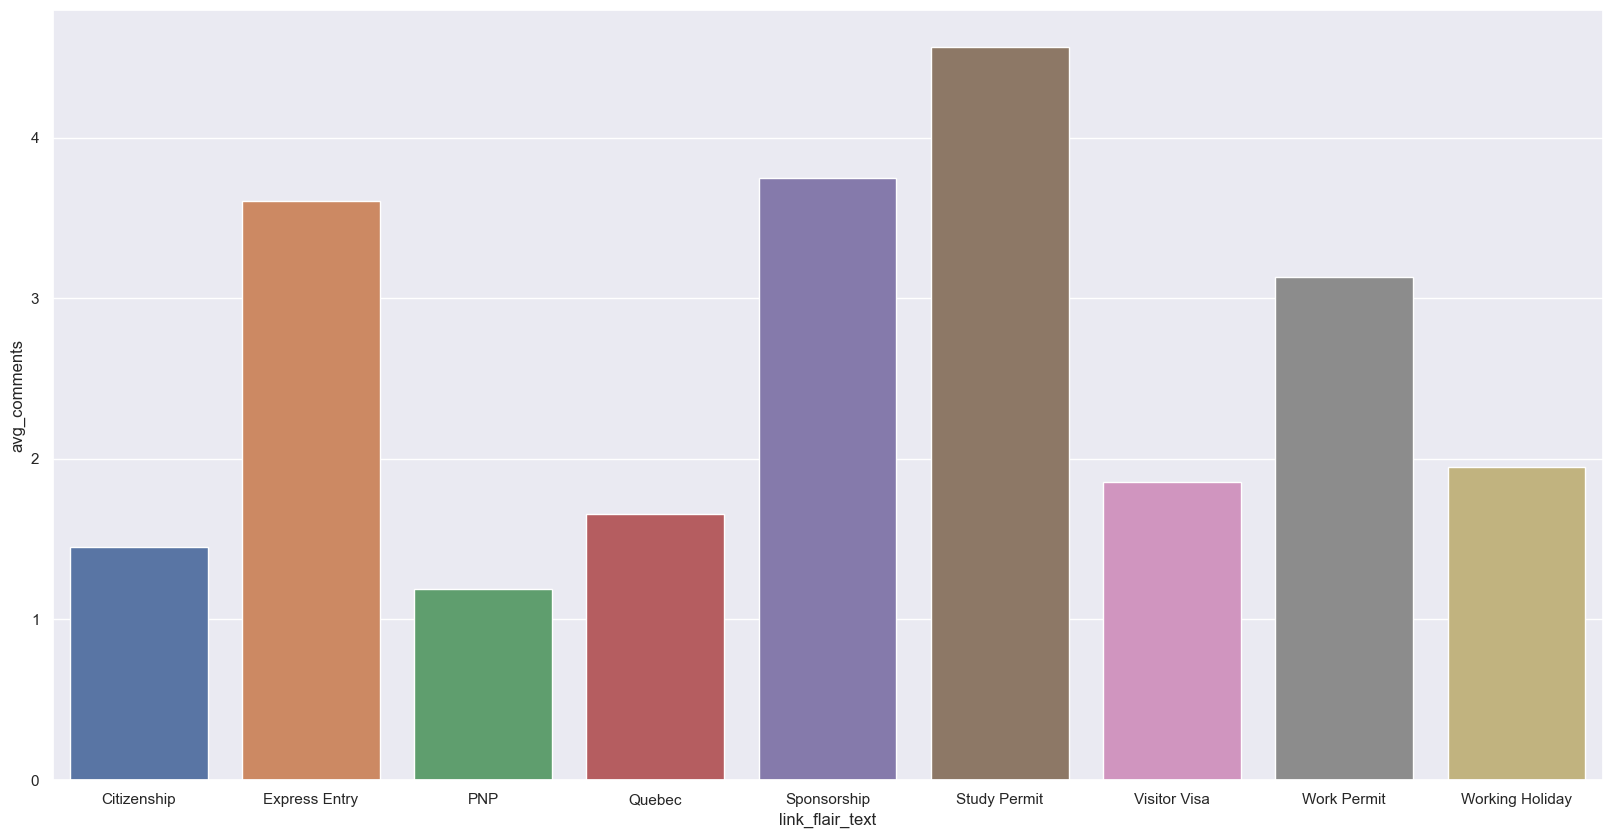

In [252]:
# Plots of average comments per category for all time
average_comment_all = average_comment_all.to_frame().reset_index()
average_comment_all = average_comment_all.rename(columns={'num_comments': 'avg_comments'})
sns.barplot(average_comment_all, x='link_flair_text', y='avg_comments')

In [340]:
# Average comments per category per year
average_comments_year = df_all_adj.groupby(by=['link_flair_text', 'Year']).mean()['num_comments']
df_avg_comments = average_comments_year.to_frame().reset_index()
df_avg_comments = df_avg_comments.rename(columns={'num_comments': 'avg_comments', "link_flair_text":"Program"})

In [341]:
px.line(df_avg_comments, x='Year', y='avg_comments', color='Program', title='Average comments per program per year')

#### b. Most mentioned issues

In [256]:
# Function for worldcloud visualization
def word_cloud_common(df, category=None, custom_stopword=None):
    # If specific category is not required
    if custom_stopword is None and category is None:
        text = "".join(i for i in df['selftext'])
        stopwords = list(STOPWORDS)
    # If specific category is required and custom_stop word
    elif custom_stopword is not None and category is not None:
        df_viz = df[df['link_flair_text'] == category]
        text = "".join(i for i in df_viz['selftext'])
        # Stopwords   
        custom_stop_words = custom_stopword
        stopwords = list(STOPWORDS) + custom_stop_words
    # If only custom stop words are available
    elif custom_stopword is not None and category is None:
        text = "".join(i for i in df['selftext'])
        # Stopwords   
        custom_stop_words = custom_stopword
        stopwords = list(STOPWORDS) + custom_stop_words
    # Visualization
    wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='white', colormap='Pastel1', stopwords=stopwords).generate(text)
    # Display wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return None

##### Top posts

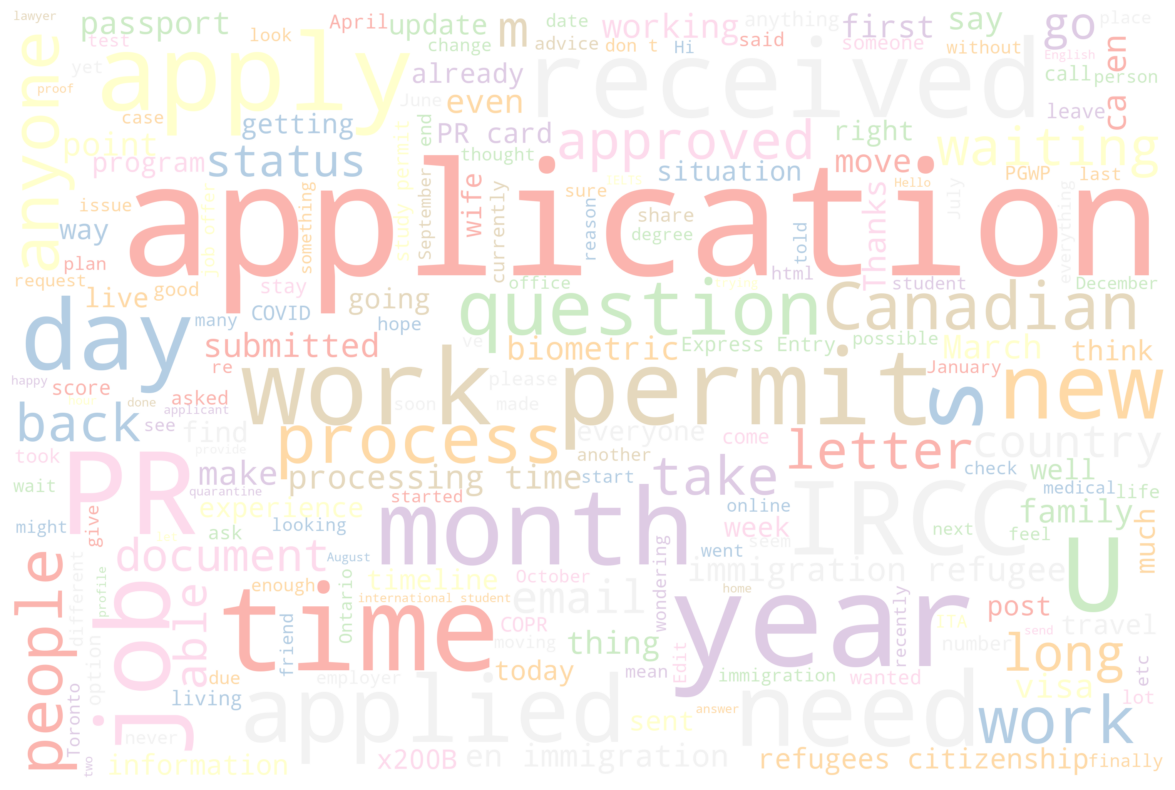

In [257]:
# Most mentioned issues for top post
top_stopwords = ['Canada', 'Thank', 'know', 'got', 'now', 'really', 'will', 'one', 'may', 'want', 'https', 'still', 'help']
word_cloud_common(df_top_adj, custom_stopword=top_stopwords)

In [258]:
df_top_adj.value_counts('link_flair_text')

link_flair_text
Study Permit              330
Express Entry             236
Work Permit               116
Sponsorship                83
Citizenship                48
Visitor Visa               22
PNP                        12
Meta                        9
Public Policy pathways      9
Working Holiday             6
Quebec                      5
dtype: int64

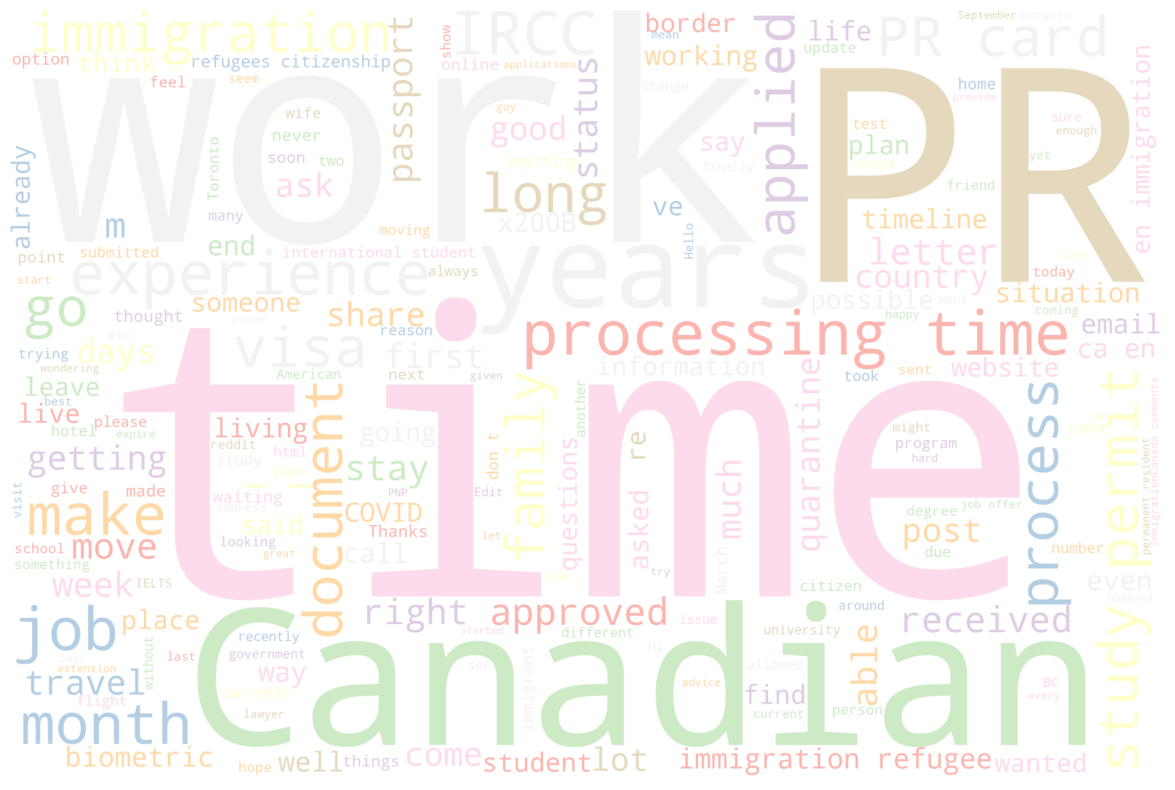

In [259]:
# Category: 'Study Permit'
additional_stopwords = ['question', 'back', 'people', 'day', 'new', 'apply', 'U', 'anyone', 'need', 'everyone', 'US', 'application', 'take', 'thing', 'year', 'S']
category_stopwords = additional_stopwords + top_stopwords
word_cloud_common(df_top_adj, 'Study Permit', category_stopwords)


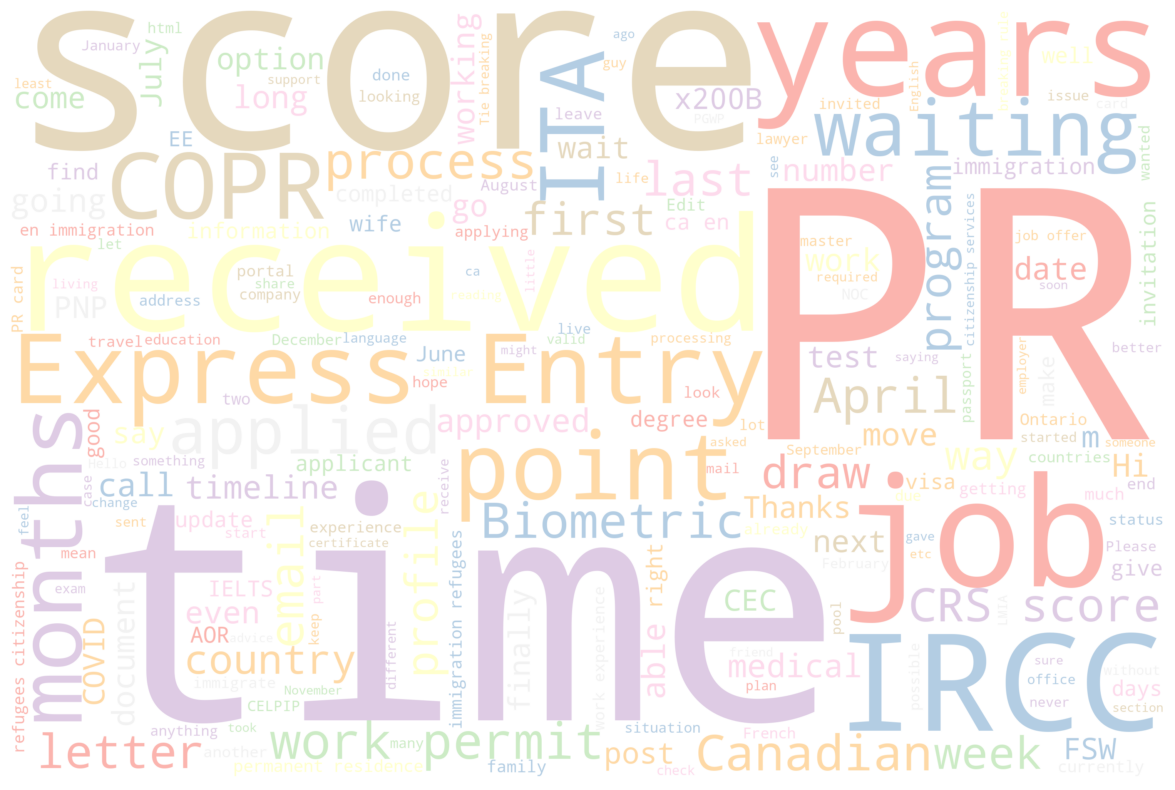

In [260]:
# Category: Express Entry
EE_stopwords = ['month', 'Express Entry', 'October', 'March', 'submitted', 'think', 'today'] + category_stopwords
word_cloud_common(df_top_adj, 'Express Entry', EE_stopwords)

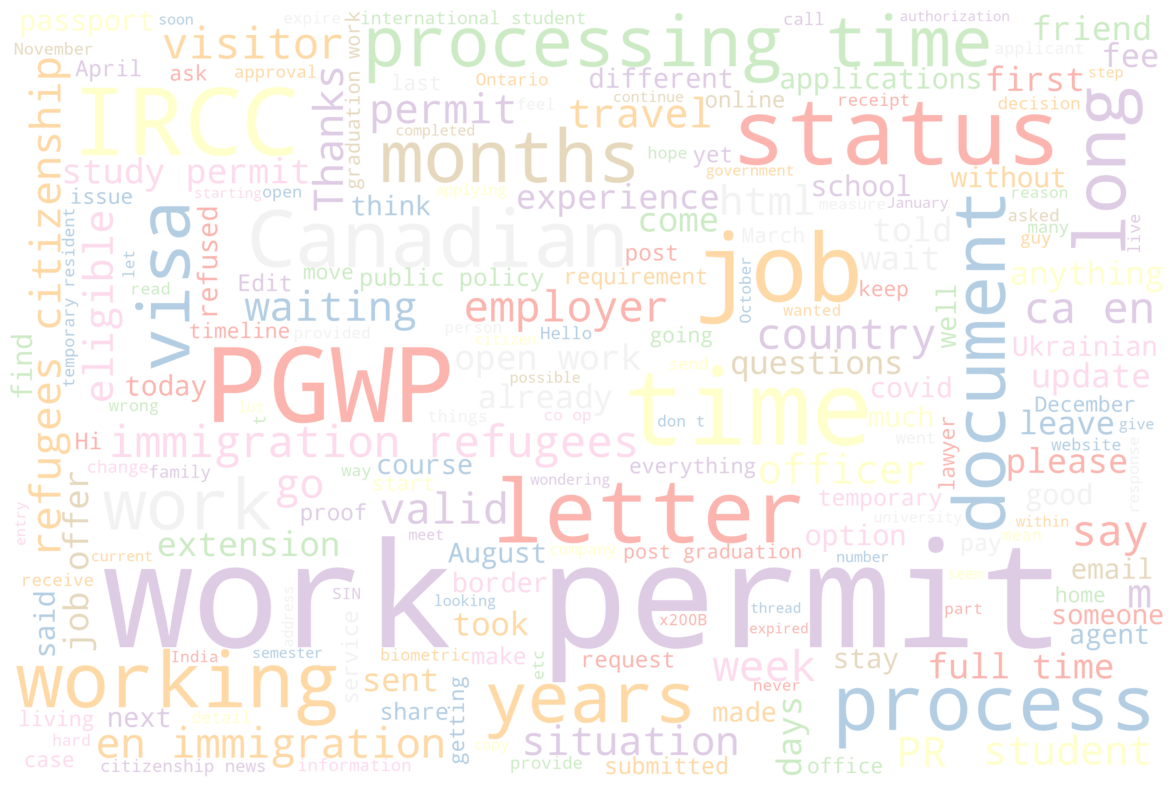

In [261]:
# Category: Work Permit
wp_stopwords = ['month','even', 'currently', 'approved', 'application', 'now', 'thank', 'will', 'work permit', 'received', 'able', 'program', 'applied'] + category_stopwords
word_cloud_common(df_top_adj, 'Work Permit', wp_stopwords)

##### All Posts

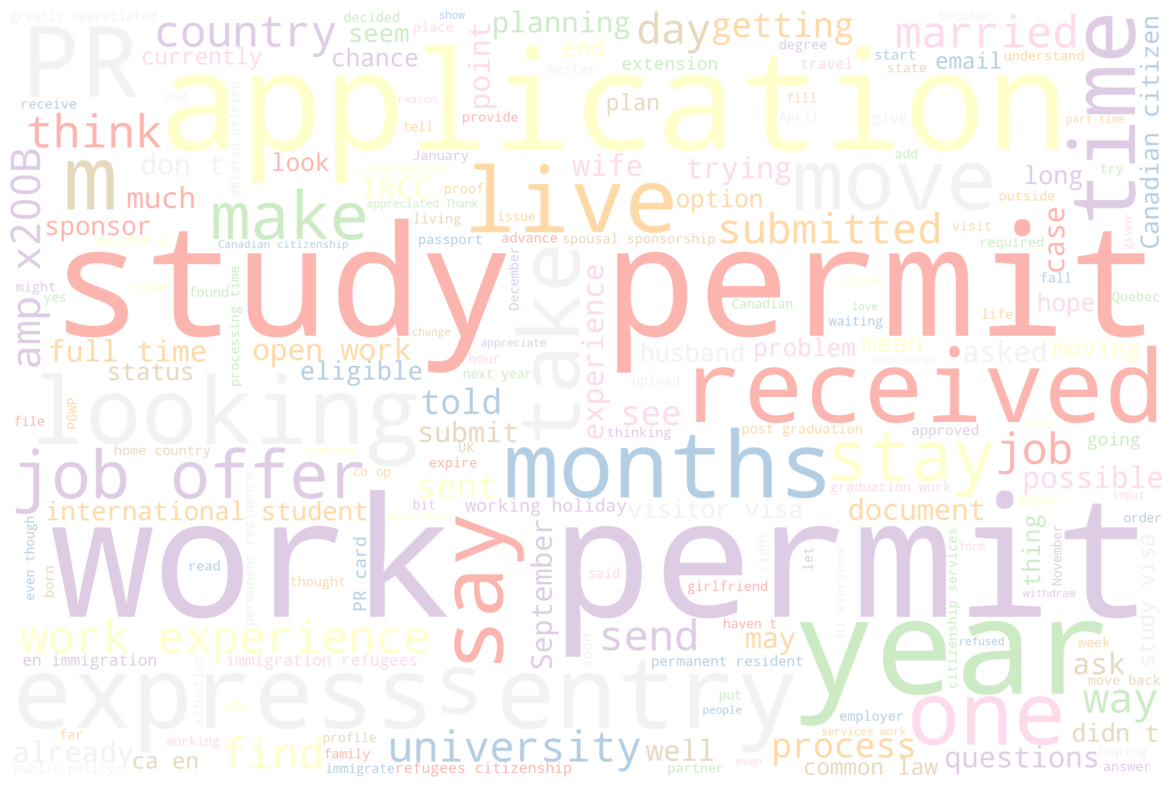

In [262]:
allpost_stopwords = ['Canada', 'apply','need', 'know', 'want', 'able', 'got', 'question', 'will', 'U', 'help', 'wondering', 'anyone', 'still', 'sure', 'advice', 'lot', 'go', 'US', 'applying', 'applied', 'now', 'month']
word_cloud_common(df_all_adj, custom_stopword = allpost_stopwords)

In [263]:
df_all_adj.value_counts('link_flair_text')

link_flair_text
Study Permit       16534
Express Entry       6967
Work Permit         5711
Sponsorship         4220
Visitor Visa        2411
Citizenship         1047
PNP                  893
Working Holiday      757
Quebec               518
dtype: int64

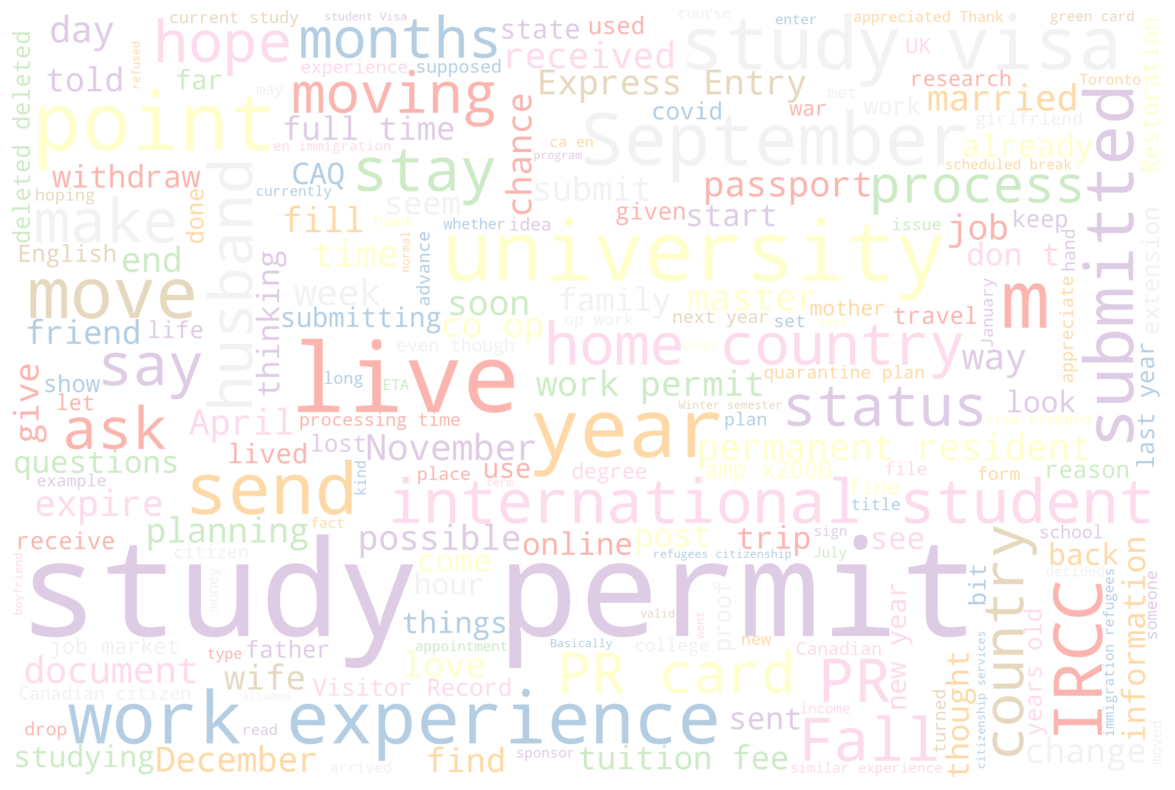

In [264]:
# Category: Study Permit
sp_stopwords_all = allpost_stopwords + ['application', 'asked', 'now', 'problem', 'think', 'S', 'looking', 'going', 'getting', 'well','anything', 'thing', 'much', 'take', 'trying', 'one', 'really', 'understand']
word_cloud_common(df_all_adj, 'Study Permit', sp_stopwords_all)

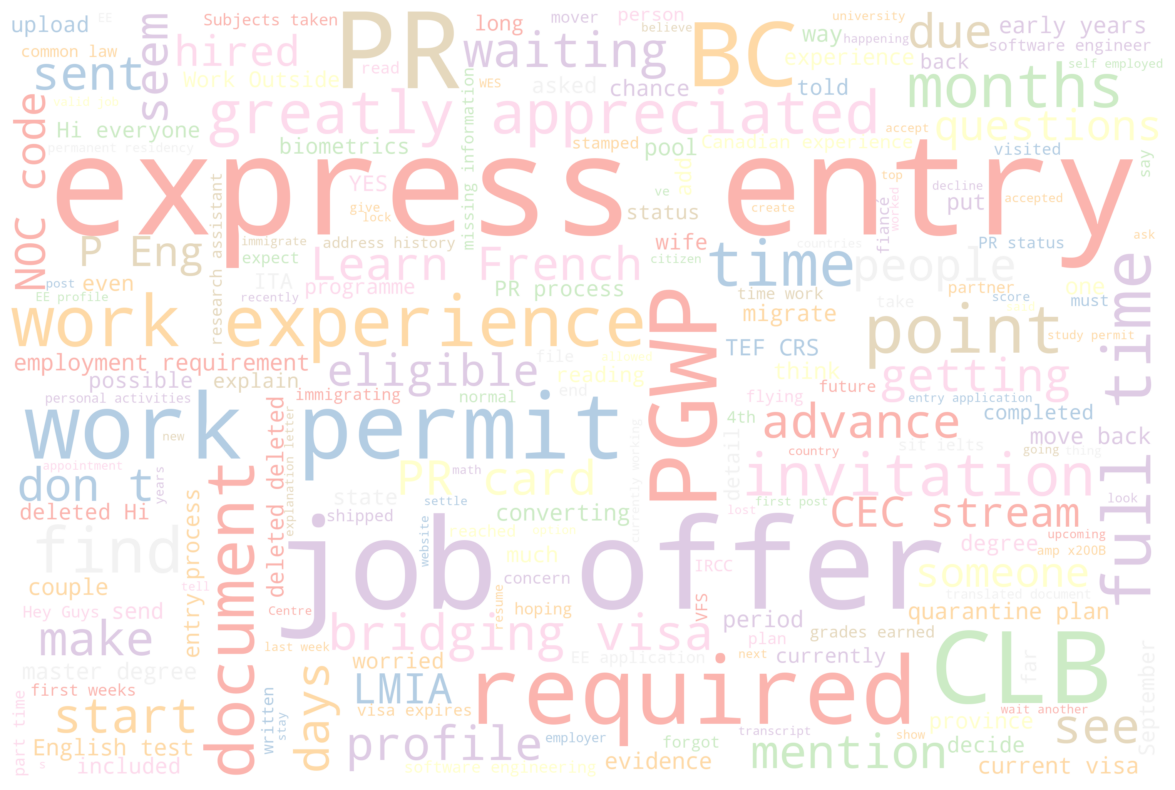

In [265]:
# Category: Express Entry
ee_stopwords_all = ['may', 'received', 'year', 'looking', 'greatly appreciated', 'already', 'deleted deleted', 'submitted', 'soon']+allpost_stopwords
word_cloud_common(df_all_adj, 'Express Entry', ee_stopwords_all)

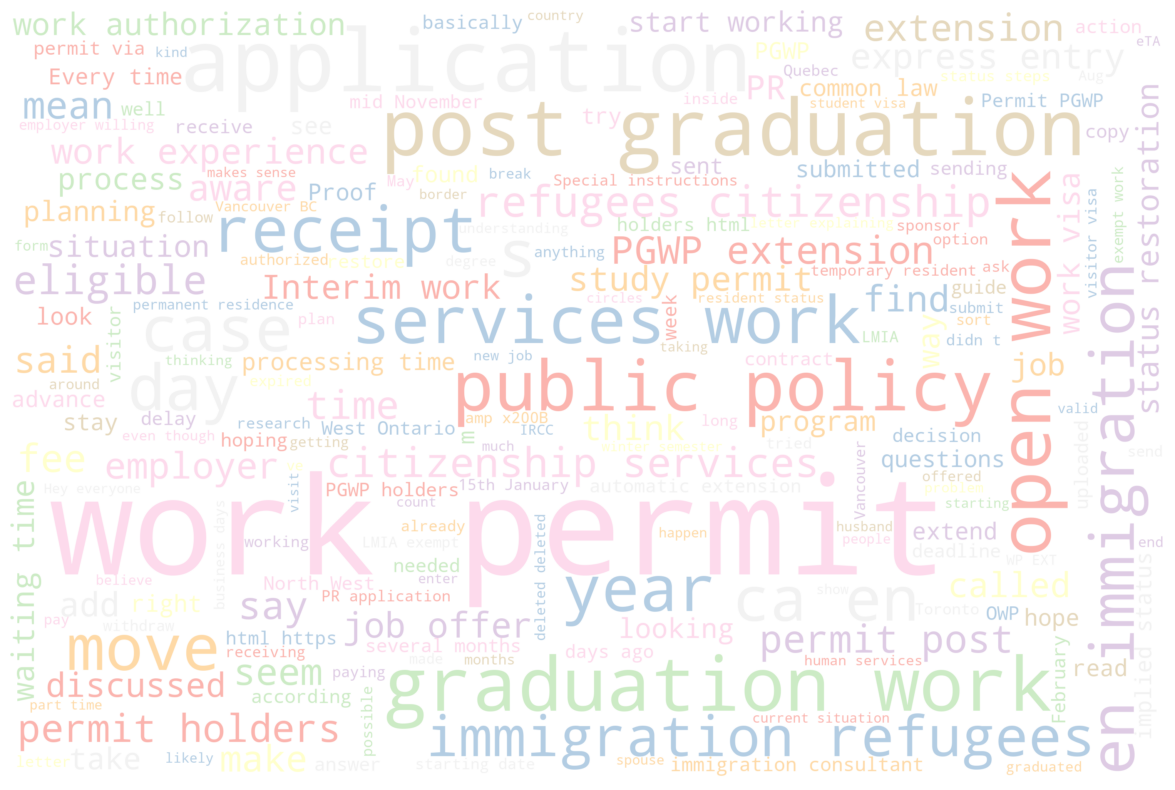

In [266]:
# Category: Work Permit
wp_stopwords_all = ['told', 'received', 'email', 'currently'] +allpost_stopwords
word_cloud_common(df_all_adj, 'Work Permit', wp_stopwords_all)

#### c. Sentimental analysis

In [282]:
# Upvote ratio by program
upvote_prog_all = df_all_adj.groupby(by=['link_flair_text']).mean()['upvote_ratio'].reset_index()
upvote_prog_top = df_top_adj.groupby(by=['link_flair_text']).mean()['upvote_ratio'].reset_index()
upvote_prog_mixed = df_mixed_adj.groupby(by=['link_flair_text']).mean()['upvote_ratio'].reset_index()


<AxesSubplot:xlabel='link_flair_text'>

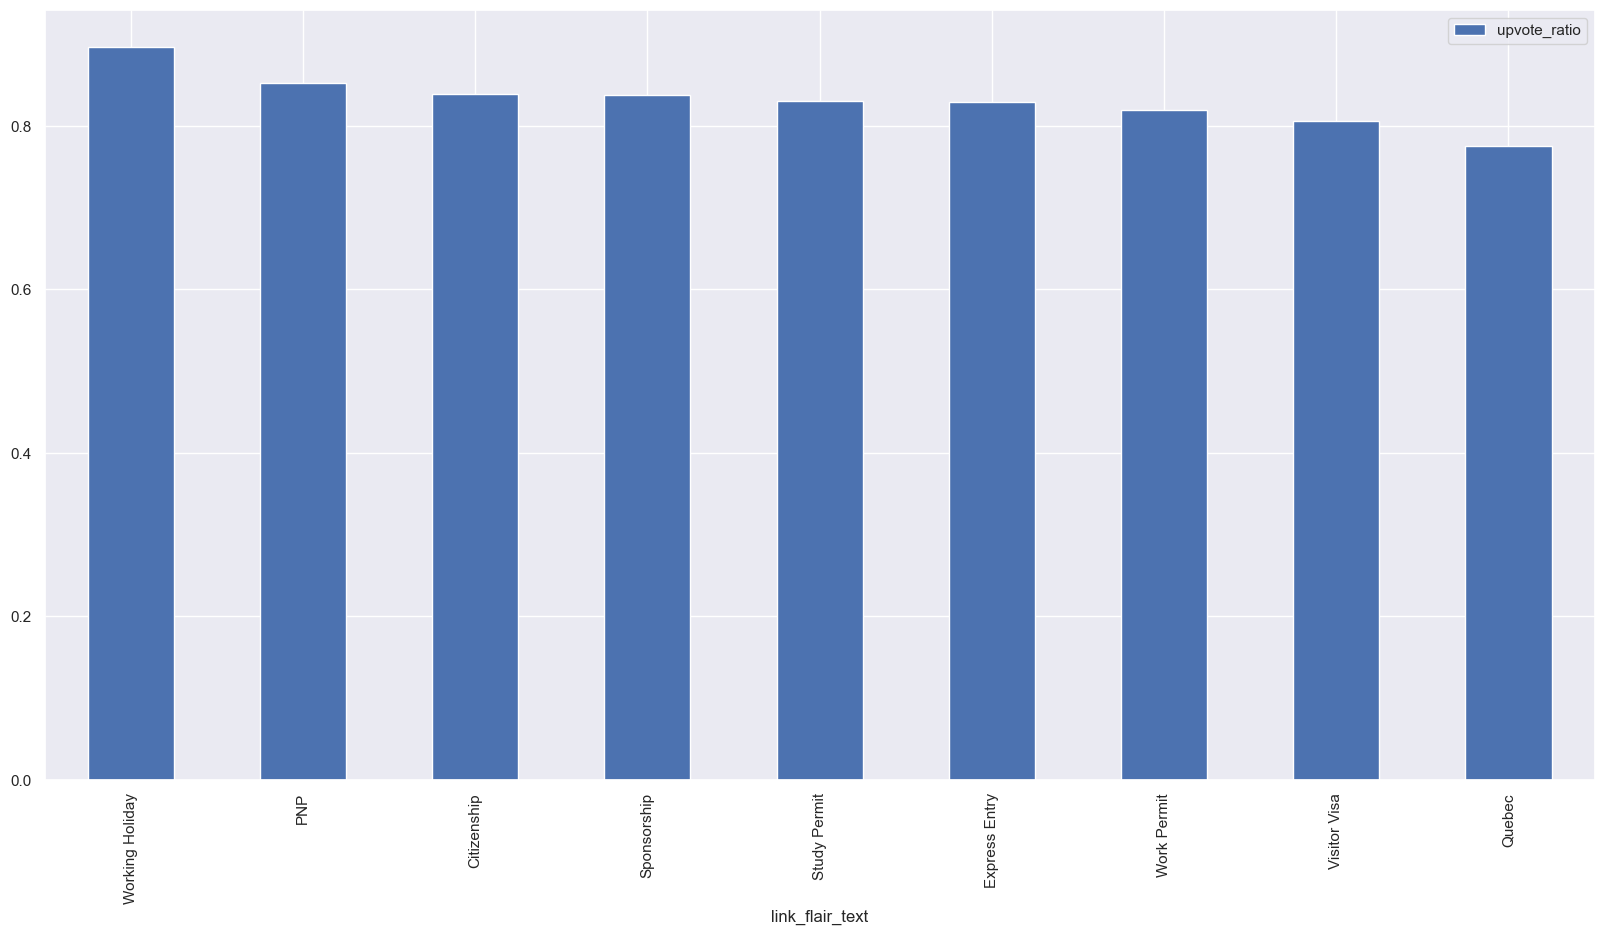

In [317]:
# Upvote ratio by program for all posts
upvote_prog_all.sort_values(by=['upvote_ratio'], ascending=False).plot.bar(x='link_flair_text', y='upvote_ratio')


<AxesSubplot:xlabel='link_flair_text'>

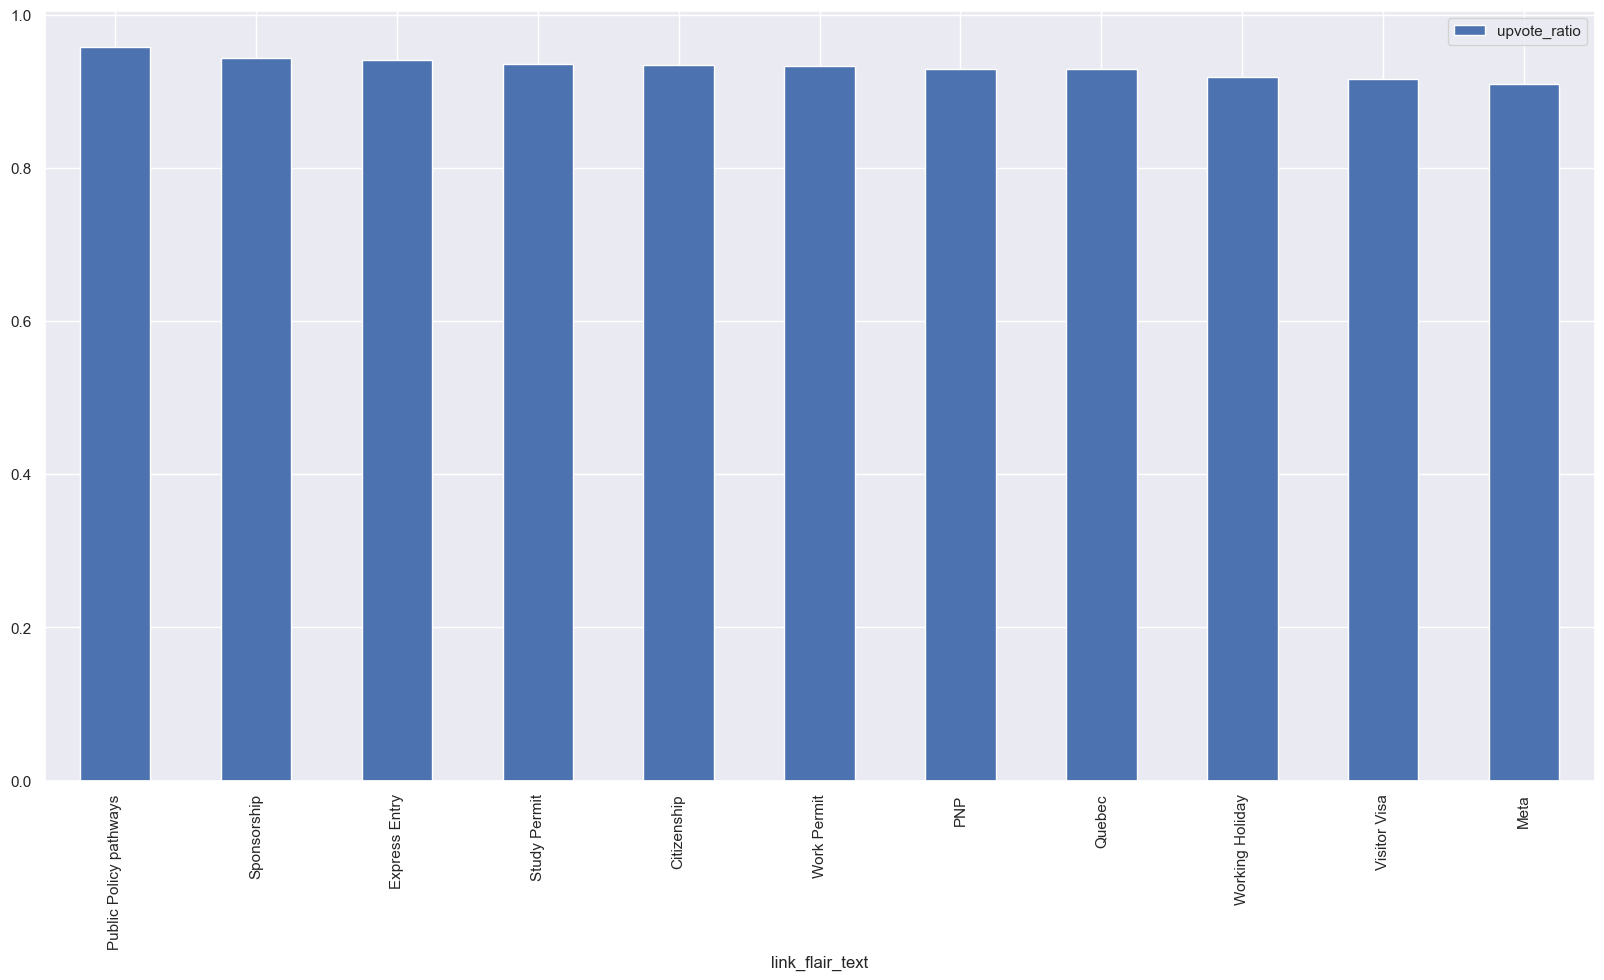

In [316]:
# Upvote ratio by program for top posts
upvote_prog_top.sort_values(by=['upvote_ratio'], ascending=False).plot.bar(x='link_flair_text', y='upvote_ratio')

<AxesSubplot:xlabel='link_flair_text'>

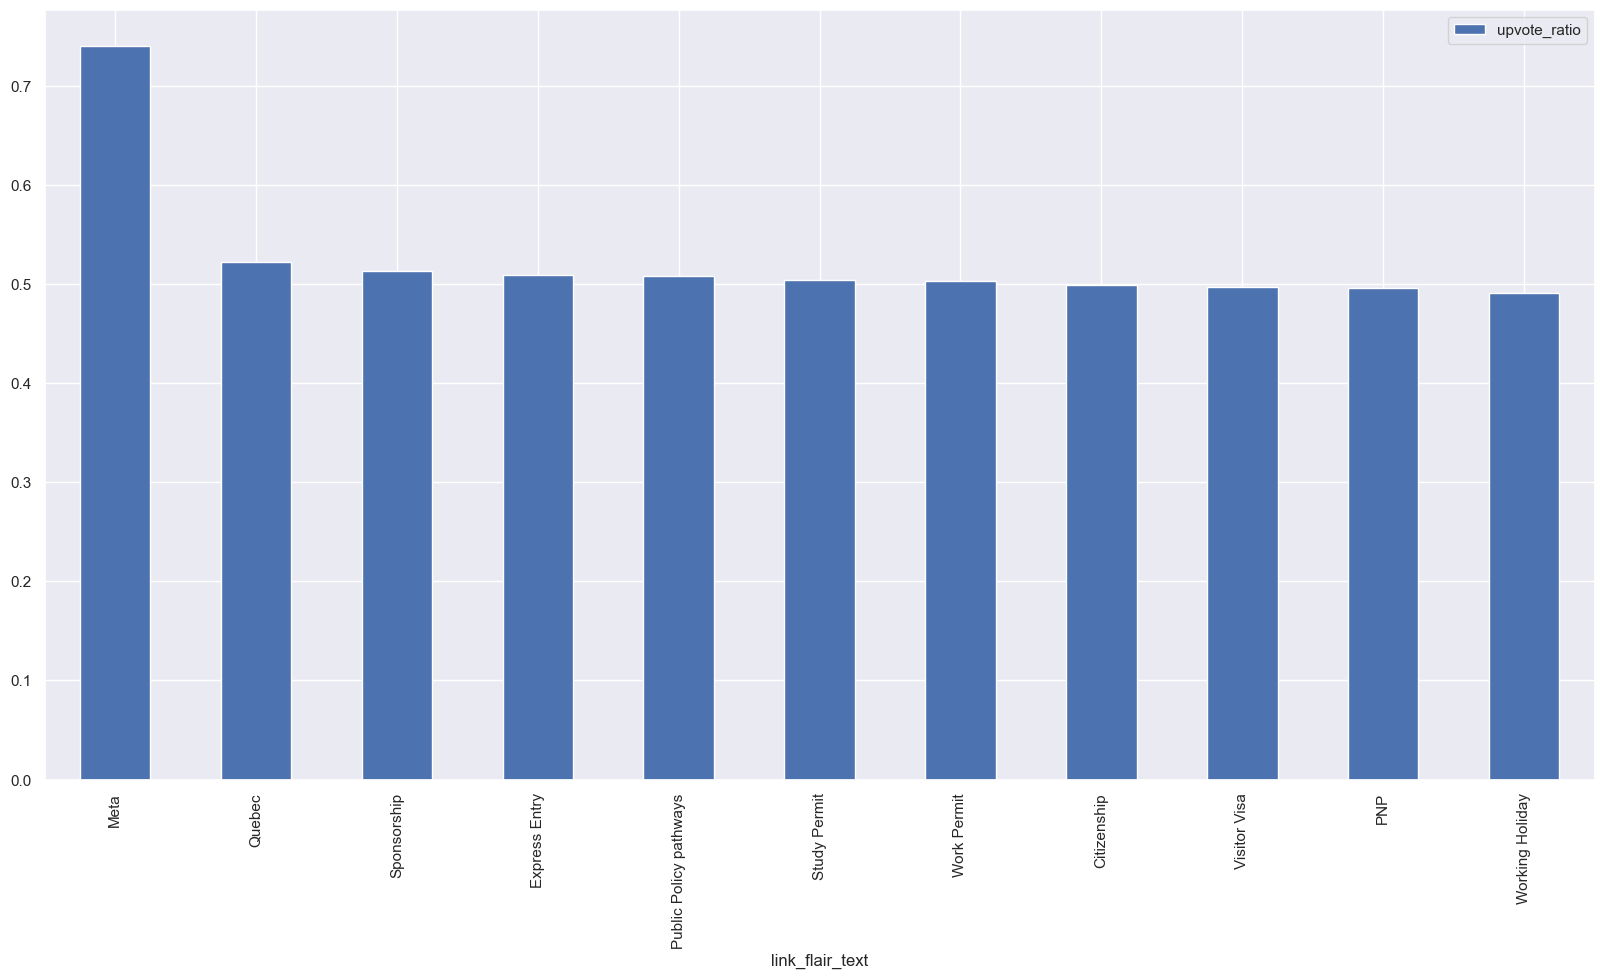

In [315]:
# Upvote ratio by program for controversial posts
upvote_prog_mixed.sort_values(by=['upvote_ratio'], ascending=False).plot.bar(x='link_flair_text', y='upvote_ratio')

In [269]:
# Calculate length of submissions
def len_submission(df):
    df['length'] = len(df['selftext'].split())
    return df

df_all_adj = df_all_adj.apply(len_submission, axis=1)

106.54224486660863


(array([3.8485e+04, 5.6900e+02, 1.0000e+00, 3.0000e+00]),
 array([1.0000e+00, 5.3050e+02, 1.0600e+03, 1.5895e+03, 2.1190e+03]),
 <BarContainer object of 4 artists>)

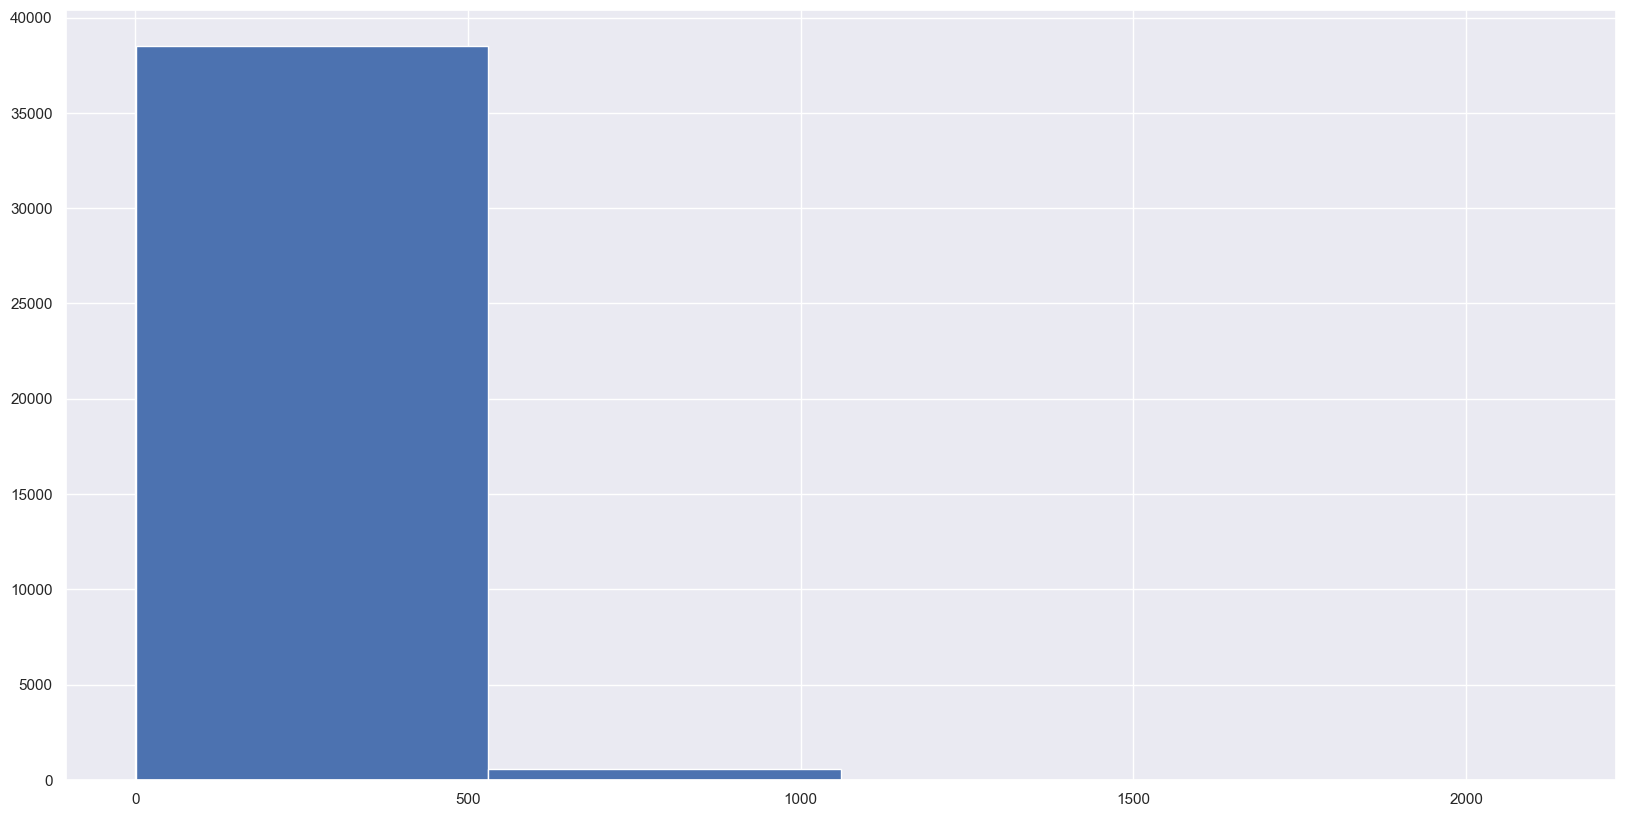

In [270]:
# Check the mean length of all submissions to check if countvectorizer is needed for sentiment analysis
print(np.mean(df_all_adj['length']))

# check length distribution of all submissions
plt.hist(df_all_adj['length'], bins=4)

In [271]:
# Initiating sentiment analysis: Using nltk

sia = SentimentIntensityAnalyzer()


In [272]:
# Sentiment scores of each post
def sentiment_scores(df):
    sentiment= sia.polarity_scores(df['selftext'])
    df['sentiment_scores'] = sentiment
    df['sentiment_negative'] = sentiment['neg']
    df['sentiment_positive'] = sentiment['pos']
    df['sentiment_neutral'] = sentiment['neu']
    return df

# Assess sentiment of each post 
def sentiment_analysis(df):
    sentiment = sia.polarity_scores(df['selftext'])
    if sentiment['neg'] >= 0.5: 
        df['sentiment'] = 'negative'
    elif sentiment['neu'] >= 0.45:
        df['sentiment'] = 'neutral'
    elif sentiment['pos'] >= 0.45:
        df['sentiment'] = 'positive'
    else: 
        df['sentiment'] = 'check'
    return df

# Sentiment analysis for each program
def program_negative_sentiment(df):
    listing = list(df['link_flair_text'].unique())
    listing.sort()
    analysis = {}
    for i in listing:
        mean_neg = np.mean(df[df['link_flair_text'] == i]['sentiment_negative'])
        analysis[i] = mean_neg
    df_analysis = pd.DataFrame.from_dict(analysis, orient='index').reset_index()
    df_analysis = df_analysis.rename(columns = {'index': 'Program', 0: 'negative_scores'})
    df_analysis = df_analysis.sort_values(by=['negative_scores'], ascending=False).reset_index(drop=True)
    return df_analysis

In [273]:
# Assess sentiment for each submission
df_all_adj = df_all_adj.apply(sentiment_analysis, axis=1)
df_top_adj = df_top_adj.apply(sentiment_analysis, axis=1)
df_mixed_adj = df_mixed_adj.apply(sentiment_analysis, axis=1)

# Assess sentiment scores for each submission
df_all_adj = df_all_adj.apply(sentiment_scores, axis=1)
df_top_adj = df_top_adj.apply(sentiment_scores, axis=1)
df_mixed_adj = df_mixed_adj.apply(sentiment_scores, axis=1)

The sentiment analysis for each program for all submissions, top submissions and controversial submissions, repeated programs that are in the top 5 of negative sentiment include:
- Study Permit
- Visitor Program
- Sponsorship
- Express Entry

<AxesSubplot:xlabel='Program'>

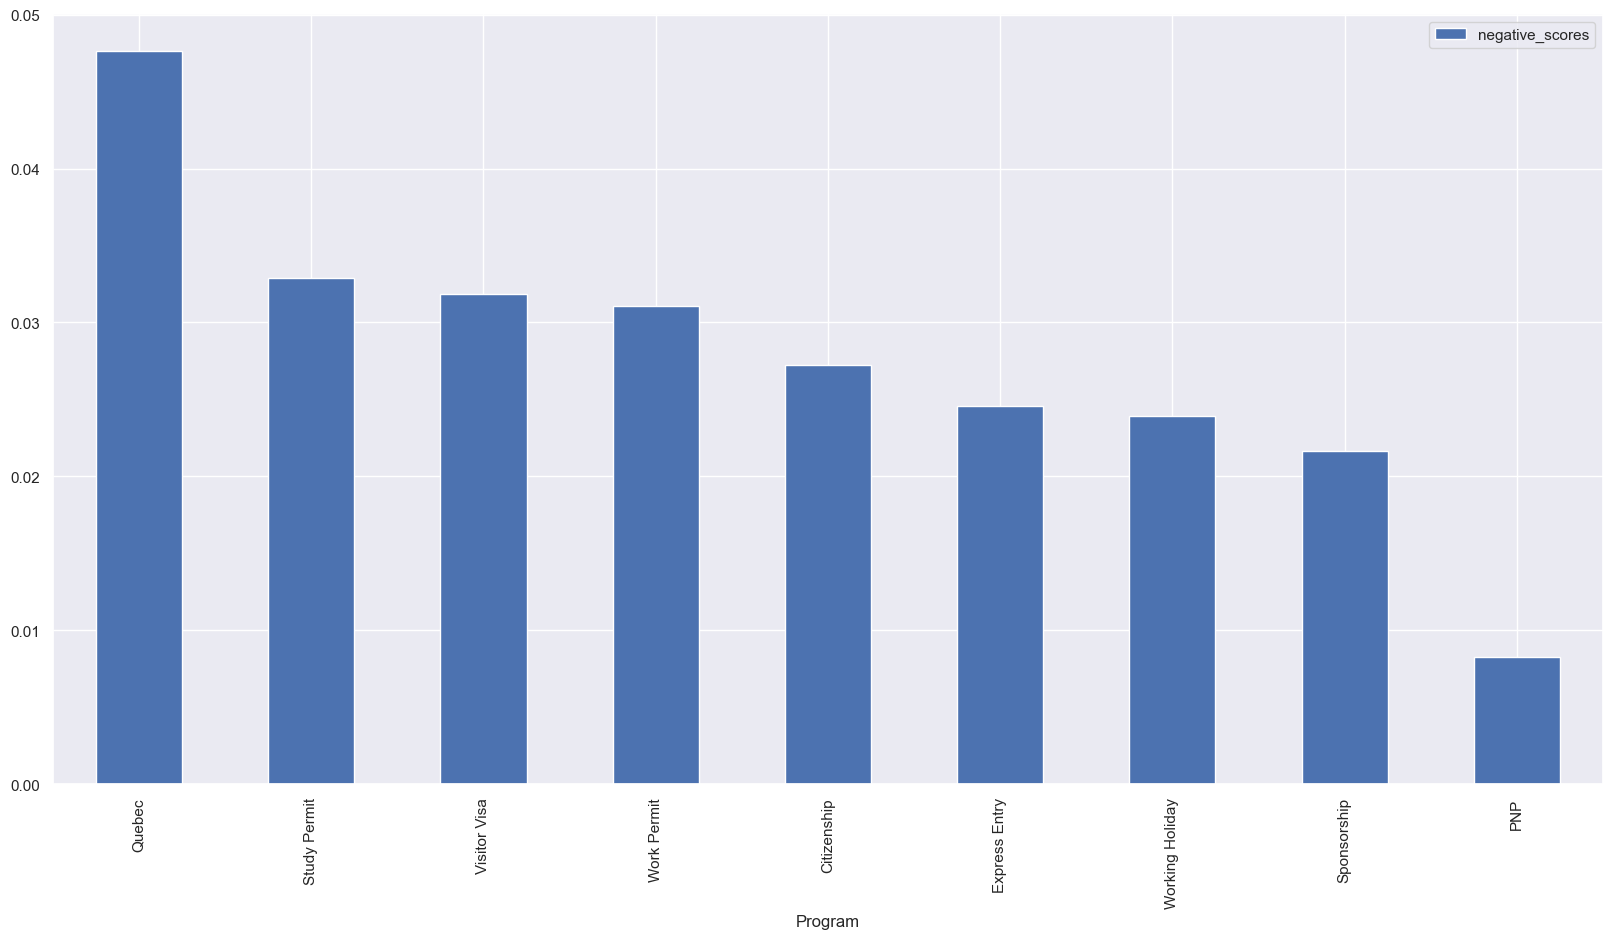

In [312]:
# Sentiment analysis for each program for all submissions
program_negative_sentiment(df_all_adj).plot.bar(x='Program', y='negative_scores')


<AxesSubplot:xlabel='Program'>

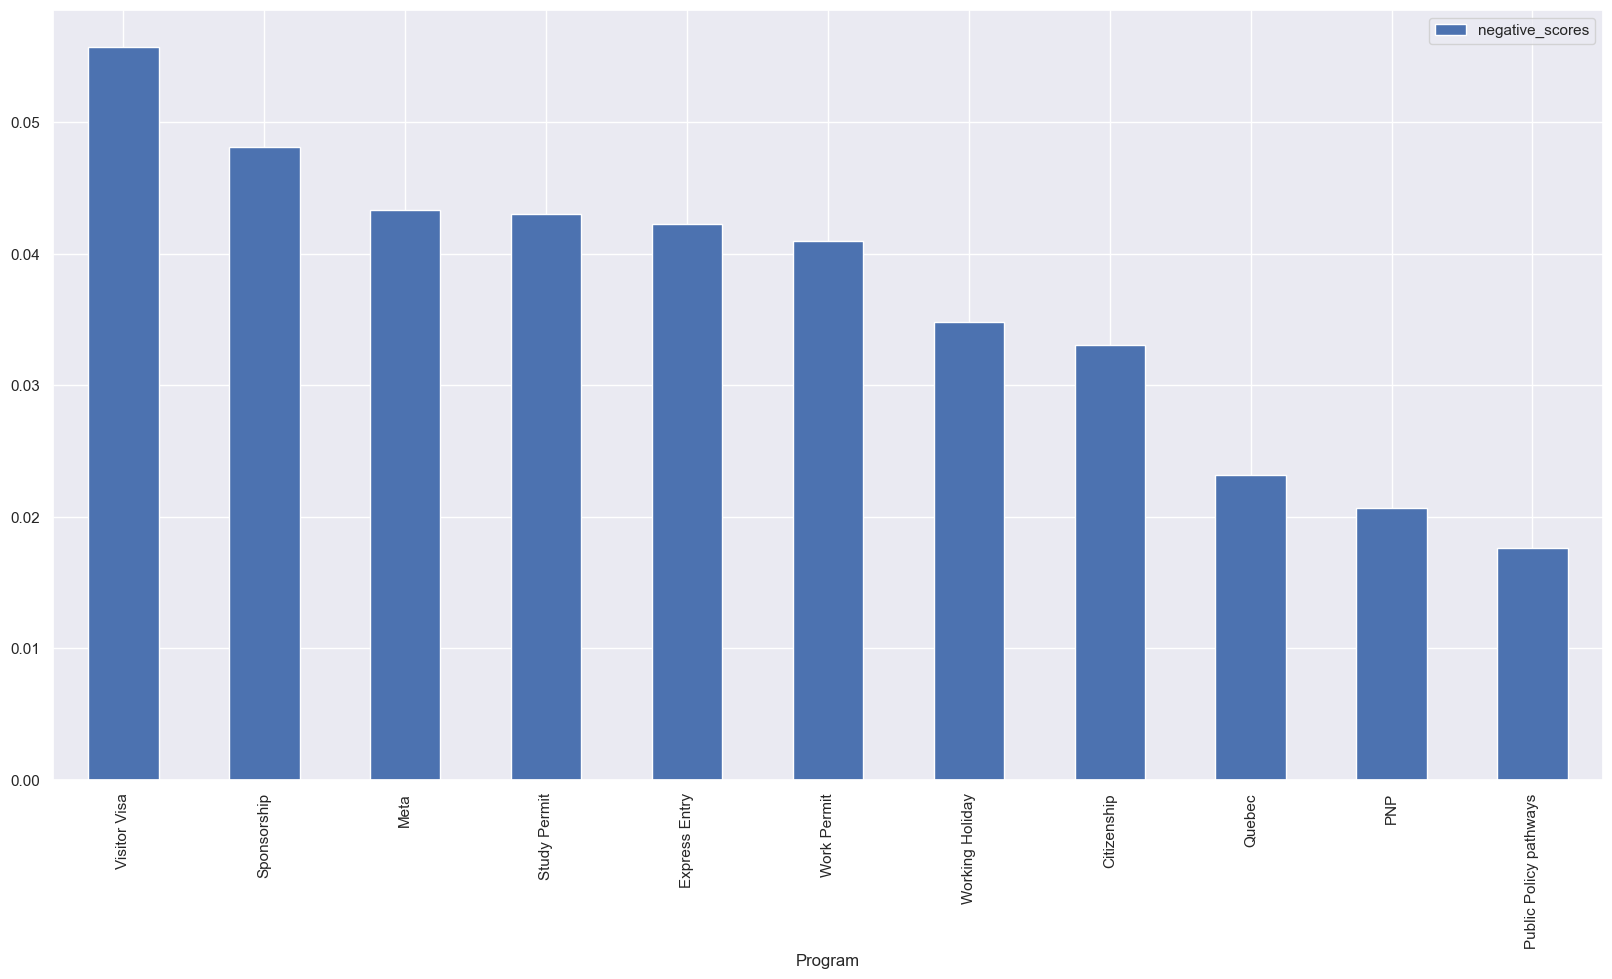

In [313]:
# Sentiment analysis for each program for top posts
program_negative_sentiment(df_top_adj).plot.bar(x='Program', y='negative_scores')

<AxesSubplot:xlabel='Program'>

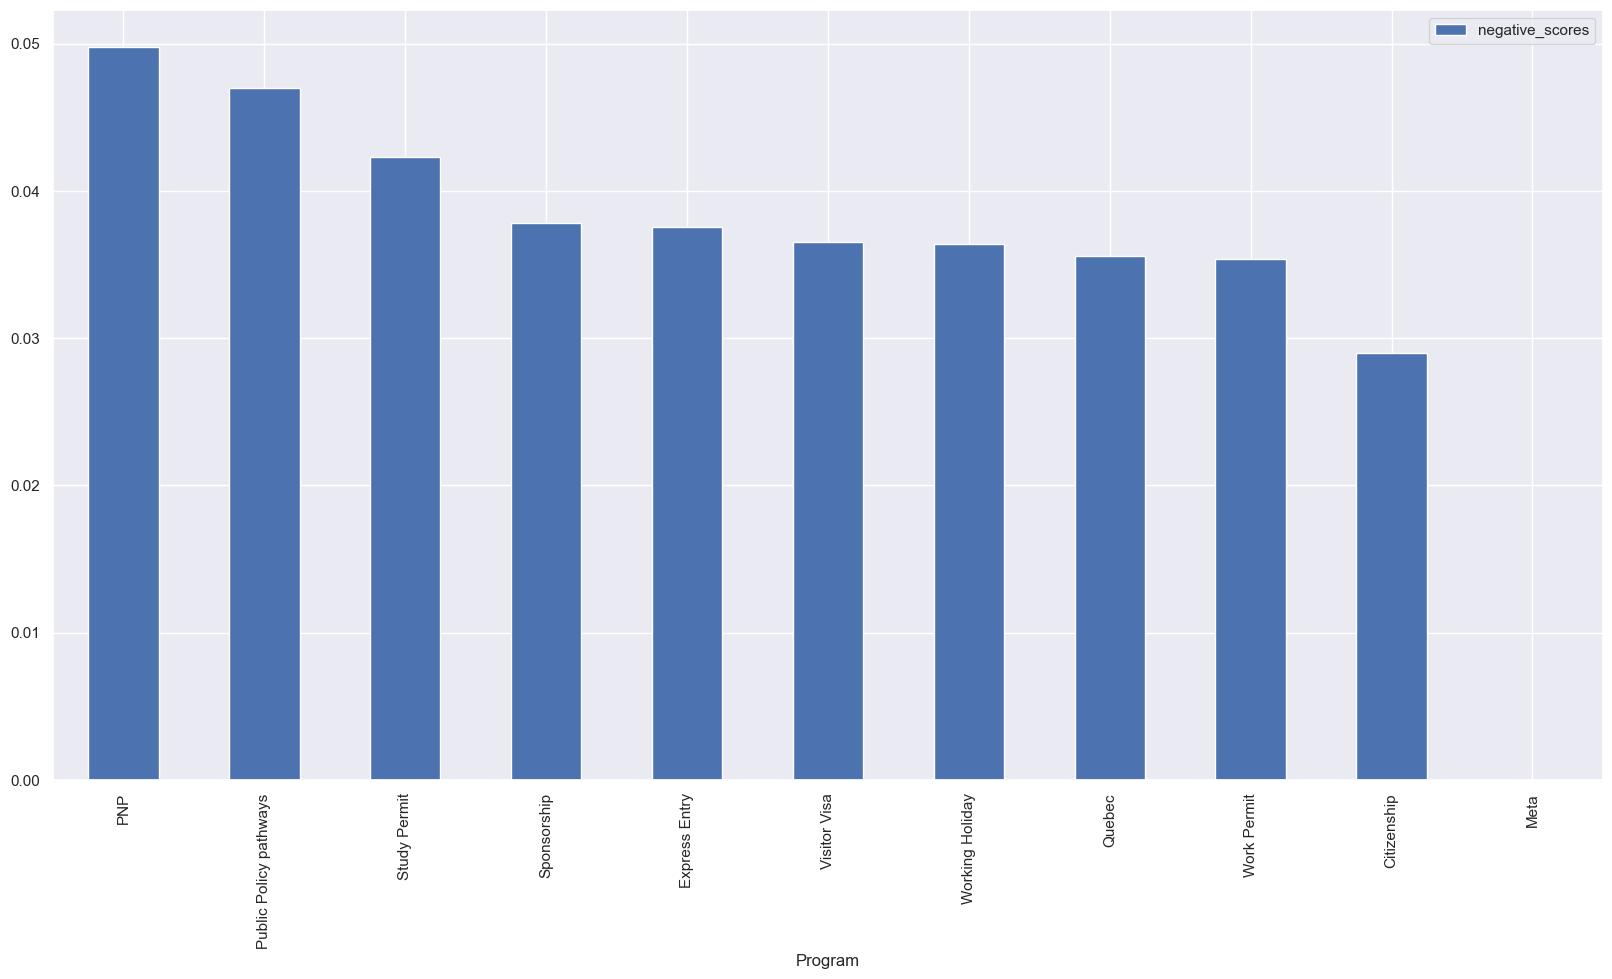

In [314]:
# Sentiment analysis for each program for controversial posts
program_negative_sentiment(df_mixed_adj).plot.bar(x='Program', y='negative_scores')

#### d. Trends observed for programs

In [306]:
# Upvote ratio by program and by year
upvote_ratio_all = df_all_adj.groupby(by=['link_flair_text', 'Year']).mean()['upvote_ratio'].reset_index()
upvote_ratio_top = df_top_adj.groupby(by=['link_flair_text', 'Year']).mean()['upvote_ratio'].reset_index()
upvote_ratio_mixed = df_mixed_adj.groupby(by=['link_flair_text', 'Year']).mean()['upvote_ratio'].reset_index()

In [307]:
# Sort upvote ratios dataframes
upvote_ratio_all = upvote_ratio_all.sort_values(by=['Year', 'link_flair_text']).reset_index(drop=True)
upvote_ratio_top = upvote_ratio_top.sort_values(by=['Year', 'link_flair_text']).reset_index(drop=True)
upvote_ratio_mixed = upvote_ratio_mixed.sort_values(by=['Year', 'link_flair_text']).reset_index(drop=True)

upvote_ratio_all = upvote_ratio_all.rename(columns={"link_flair_text": "Program"})
upvote_ratio_top = upvote_ratio_top.rename(columns={'link_flair_text': "Program"})
upvote_ratio_mixed = upvote_ratio_mixed.rename(columns={'link_flair_text': "Program"})

upvote_ratio_all['upvote_ratio'] = upvote_ratio_all['upvote_ratio'].fillna(0)
upvote_ratio_top['upvote_ratio'] = upvote_ratio_top['upvote_ratio'].fillna(0)
upvote_ratio_mixed['upvote_ratio'] = upvote_ratio_mixed['upvote_ratio'].fillna(0)


In [309]:
# Upvote ratio (sentiment) by program and year - All posts
fig_upvote_all = px.line(upvote_ratio_all, x="Year", y="upvote_ratio", color='Program', title= "Upvote ratio by program and by year - All posts")
fig_upvote_all.show()

In [310]:
fig_upvote_top = px.line(upvote_ratio_top, x='Year', y='upvote_ratio', color='Program', title= "Upvote ratio by program and by year - Top posts")
fig_upvote_top.show()

In [311]:
fig_upvote_mixed = px.line(upvote_ratio_mixed, x='Year', y='upvote_ratio', color='Program', title="Upvote ratio by program and by year - Controversial posts")
fig_upvote_mixed.show()

In [277]:
# Function to create sentiment scores for each program on each year

def sentiment_by_year(df):
    list_years = list(df['Year'].unique())
    df_return = pd.DataFrame()
    for i in list_years:
        df_year = df[df['Year'] == i]
        df_temp = program_negative_sentiment(df_year)
        df_temp['Year'] = i
        df_return = pd.concat([df_temp, df_return], ignore_index=True)
    return df_return
        
    

In [318]:
# Negative scores for all posts
all_post_negative_scores = sentiment_by_year(df_all_adj)
all_post_negative_scores = all_post_negative_scores.sort_values(by=['Year', 'Program']).reset_index(drop=True)

# Trends observed for programs for all posts 
fig = px.line(all_post_negative_scores, x="Year", y="negative_scores", color='Program', title='Negative scores by program and by year - All posts')
fig.show()

In [319]:
# Negative scores of top posts
top_post_negative_scores = sentiment_by_year(df_top_adj)
top_post_negative_scores = top_post_negative_scores.sort_values(by=['Year', 'Program']).reset_index(drop=True)

# Trends observed for programs for top posts
fig_top = px.line(top_post_negative_scores, x='Year', y='negative_scores', color='Program', title='Negative scores by program and by year - Top posts')
fig_top.show()

In [320]:
# Negative scores of controversial posts
mixed_post_negative_scores = sentiment_by_year(df_mixed_adj)
mixed_post_negative_scores = mixed_post_negative_scores.sort_values(by=['Year', 'Program']).reset_index(drop=True)

# Trends observed for programs for controversial posts
fig_mixed = px.line(mixed_post_negative_scores, x="Year", y='negative_scores', color='Program', title = 'Negative scores by program and by year - Controversial posts')
fig_mixed.show()

### Points of improvements

#### a. Contentious topics

#### b. Process pain points

#### c. Programs requires most improvements

## Visual deliverables